In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import h5py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns # For confusion matrix visualization
!pip install -q umap-learn
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
from tqdm import tqdm
import pickle
import joblib
import torch
from io import BytesIO
import base64


In [ ]:
# mount to google drive to access csv located in my google drive
#drive.mount('/content/drive/')
#os.getcwd()
#os.chdir('drive/MyDrive/GradSchool/CHEM_269/Act3')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/GradSchool/CHEM_269/Act3'

## Exercise 1: Rhea Database
#### I looked around the Rhea website, and under 'Browse', I was able to see that you can browse reactions based on if they are involved with proteins, nucleic acids,  and even specific classes of enzymes (hydrolases, ligases, etc.) You can also look up molecule scaffolds by 'scaffold', drawing them in a window and then it will return all molecules that have that chemical motif. Then you can look at the proteins that molecule is associated with and reactions that are in the database.

In [ ]:
#load smiles strings as a pandas database
df = pd.read_csv('rhea_steroid_smiles.txt', header=None, sep="  ")
df2 = df.set_axis(['compound_id', 'smiles'], axis=1) #set columns

<ipython-input-6-f3f40bfd5381>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('rhea_steroid_smiles.txt', header=None, sep="  ")


In [ ]:
df2.head()

compound_id                                             smiles
0  Compound 1  [H][C@]12CC[C@]3([H])[C@]([H])(CC[C@]4(C)[C@@H...
1  Compound 2  [H][C@@]12CCC3=CC(=O)CC[C@]3(C)[C@@]1([H])CC[C...
2  Compound 3  [H][C@@]12CC[C@]([H])([C@H](C)CC[C@H](O)C(C)C)...
3  Compound 4             *C1CCC2C3CCC4CCCCC4(C)C3[C@@H](O)CC12C
4  Compound 5   CC(C)CC[C@H](O)C(C)C1CCC2C3CCC4CCCCC4(C)C3CCC21C

In [ ]:
!pip install rdkit
!pip install py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, MACCSkeys, rdMolDescriptors
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D


In [ ]:
df2.columns

Index(['compound_id', 'smiles'], dtype='object')

In [ ]:
#add a column with the rdkit molecule object for visualization
df2['mol'] = df2['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

## [EXERCISE 2] display some molecules in 2D and 3D

In [ ]:
import py3Dmol

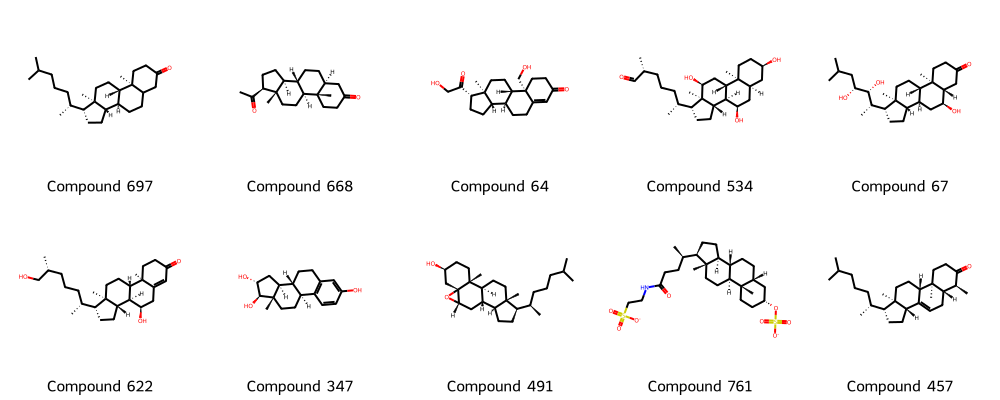

In [ ]:
#get a random sample of 10 compounds from our dataset
sample_df = df2.sample(n=10, random_state=42)
Draw.MolsToGridImage(sample_df['mol'].tolist(), legends = sample_df['compound_id'].tolist(), molsPerRow=5)

In [ ]:
# Create 3D representations of random molecules
def generate_3d_molecule(mol):
  mol = Chem.AddHs(mol) #add hydrogens
  AllChem.EmbedMolecule(mol, AllChem.ETKDG()) #"Experimental-Torsion Knowledge Distance Geometry" to generate a 3D conformation based on known chemical information
  AllChem.UFFOptimizeMolecule(mol)
  return mol

sample_df = df2.sample(n = 10, random_state = 42)

#add a column with the 3D molecules
sample_df['3d_mol'] = sample_df['mol'].apply(lambda x: generate_3d_molecule(x) if x else None)


def visualize_single_molecule(mol, title="Molecule"):
  viewer = py3Dmol.view(width=400, height=400)
  mol_block = Chem.MolToMolBlock(mol)
  viewer.addModel(mol_block,"mol")
  viewer.setStyle({"stick": {}})
  viewer.setBackgroundColor("0xeeeeee")
  viewer.zoomTo()
  viewer.show()

In [ ]:
for idx, row in sample_df.iterrows():
  if row['3d_mol']:
    visualize_single_molecule(row['3d_mol'], title=row['compound_id'])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## [EXERCISE 3] Generate molecular fingerprints
####

In [ ]:
#make new dataframe with columns for new fingerprints
original_cols = ['compound_id', 'smiles', 'mol']
fingerprint_cols = ['Morgan', 'Topological', 'MACCS', 'AtomPair', 'Torsion']

df = df2[original_cols]

In [ ]:
#compute a bunch of different kinds of fingerprints
def compute_fingerprints(mol):
    if mol is None:
      return None

    return {
        "Morgan": np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)),
        "Topological": np.array(Chem.RDKFingerprint(mol)),
        "MACCS": np.array(MACCSkeys.GenMACCSKeys(mol)),
        "AtomPair": np.array(AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)),
        "Torsion": np.array(AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
    }

In [ ]:
#apply the function to all molecules
df['fingerprints'] = df['mol'].apply(compute_fingerprints)

#now our dataframe should have all the fingerprints in columns!
fingerprint_df = df['fingerprints'].apply(pd.Series)
df = pd.concat([df, fingerprint_df], axis=1).drop(columns=['fingerprints'])


In [ ]:
df.head()

compound_id                                             smiles  \
0  Compound 1  [H][C@]12CC[C@]3([H])[C@]([H])(CC[C@]4(C)[C@@H...   
1  Compound 2  [H][C@@]12CCC3=CC(=O)CC[C@]3(C)[C@@]1([H])CC[C...   
2  Compound 3  [H][C@@]12CC[C@]([H])([C@H](C)CC[C@H](O)C(C)C)...   
3  Compound 4             *C1CCC2C3CCC4CCCCC4(C)C3[C@@H](O)CC12C   
4  Compound 5   CC(C)CC[C@H](O)C(C)C1CCC2C3CCC4CCCCC4(C)C3CCC21C   

                                                mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56af80>   
1  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56aea0>   
2  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56aff0>   
3  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56b060>   
4  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56b0d0>   

                                              Morgan  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...   
2  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   

                                         Topological  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               MACCS  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            AtomPair  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                             Torsion  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
def compute_morgan_fingerprints(mol, radius = 2, nBits=1024):
  return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))

df['Morgan_FP'] = df['mol'].apply(lambda x: compute_morgan_fingerprints(x) if x else None)

#make fingerpritns into numpy array for umap
fingerprint_matrix = np.stack(df['Morgan_FP'].values)

#apply umap
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="jaccard", n_components=2, random_state=42)
umap_projection = umap_model.fit_transform(fingerprint_matrix)

#
df['umap-1'] = umap_projection[:, 0]
df['umap-2'] = umap_projection[:, 1]

#put umap coordinates into a dataframe
df.loc[df['Morgan_FP'].notna(), ['umap-1', 'umap-2']]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap-1     umap-2
0    14.484487   9.424206
1     9.266295   7.464049
2    11.438838  14.588492
3    15.144756   9.017923
4     5.832720  12.577483
..         ...        ...
795  11.956646  10.034628
796  14.505656   9.364702
797  10.641952   6.567559
798  14.633859   7.261965
799   7.553820  -3.353816

[800 rows x 2 columns]

In [ ]:
# Function to generate 2D molecular images
from PIL import Image
import io
def mol_to_base64(smiles_string):
    """
    Converts a SMILES string to a base64 encoded PNG image of the molecule.
    """
    mol = Chem.MolFromSmiles(smiles_string) # Convert SMILES string to RDKit Mol object
    if mol:
        drawer = rdMolDraw2D.MolDraw2DCairo(250, 250)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return "data:image/png;base64," + base64.b64encode(buffered.getvalue()).decode()
    return None
# Assuming you have 'smiles_df' with a 'SMILES' column
df["mol_image"] = df["smiles"].apply(mol_to_base64)

In [ ]:
df.head()

compound_id                                             smiles  \
0  Compound 1  [H][C@]12CC[C@]3([H])[C@]([H])(CC[C@]4(C)[C@@H...   
1  Compound 2  [H][C@@]12CCC3=CC(=O)CC[C@]3(C)[C@@]1([H])CC[C...   
2  Compound 3  [H][C@@]12CC[C@]([H])([C@H](C)CC[C@H](O)C(C)C)...   
3  Compound 4             *C1CCC2C3CCC4CCCCC4(C)C3[C@@H](O)CC12C   
4  Compound 5   CC(C)CC[C@H](O)C(C)C1CCC2C3CCC4CCCCC4(C)C3CCC21C   

                                                mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56af80>   
1  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56aea0>   
2  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56aff0>   
3  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56b060>   
4  <rdkit.Chem.rdchem.Mol object at 0x79b5eb56b0d0>   

                                              Morgan  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...   
2  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   

                                         Topological  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               MACCS  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            AtomPair  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                             Torsion  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                           Morgan_FP     umap-1     umap-2  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  14.484487   9.424206   
1  [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...   9.266295   7.464049   
2  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  11.438838  14.588492   
3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  15.144756   9.017923   
4  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   5.832720  12.577483   

                                           mol_image  
0  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
1  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
2  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
3  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
4  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...

In [ ]:
# Function to generate 2D molecular images
from PIL import Image
import io
def mol_to_base64(smiles_string):
    """
    Converts a SMILES string to a base64 encoded PNG image of the molecule.
    """
    mol = Chem.MolFromSmiles(smiles_string) # Convert SMILES string to RDKit Mol object
    if mol:
        drawer = rdMolDraw2D.MolDraw2DCairo(250, 250)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return "data:image/png;base64," + base64.b64encode(buffered.getvalue()).decode()
    return None
# Assuming you have 'smiles_df' with a 'SMILES' column
df["mol_image"] = df["smiles"].apply(mol_to_base64)

In [ ]:
# Assuming df has these columns:
# - UMAP_1, UMAP_2: UMAP coordinates
# - mol_image: base64 encoded image string or path to image
# - molecule_id: unique identifier for each molecule
# - smiles: SMILES representation (optional)


def create_interactive_molecule_plot(df):
   """
   Create an interactive plot where hovering/clicking on points shows molecule structures.

   Parameters:
   df (pandas.DataFrame): DataFrame with columns UMAP_1, UMAP_2, mol_image, molecule_id

   Returns:
   plotly.graph_objects.Figure: Interactive figure
   """
   # Create figure with secondary y-axis
   fig = make_subplots(specs=[[{"secondary_y": True}]])

   # Create custom hover template
   hover_template = (
       "<b>Molecule ID:</b> %{customdata[0]}<br>"
       "<b>Click to view structure</b><br>"
   )

   if "smiles" in df.columns:
       hover_template = (
           "<b>Molecule ID:</b> %{customdata[0]}<br>"
           "<b>Click to view structure</b><br>"
       )
       custom_data = np.stack((df["compound_id"], df["smiles"]), axis=1)
   else:
       custom_data = np.array(df["compound_id"]).reshape(-1, 1)

   # Add scatter trace
   fig.add_trace(
       go.Scatter(
           x=df["umap-1"],
           y=df["umap-2"],
           mode="markers",
           marker=dict(
               size=8,
               opacity=0.7,
               color=df.index,  # Color by index for distinction
               colorscale="Viridis",
               showscale=False
           ),
           customdata=custom_data,
           hovertemplate=hover_template,
           name="Molecules"
       ),
       secondary_y=False,
   )

   # Update layout
   fig.update_layout(
       title="Molecule UMAP Visualization",
       title_x=0.5,
       xaxis_title="UMAP Dimension 1",
       yaxis_title="UMAP Dimension 2",
       hovermode="closest",
       template="plotly_white",
       width=900,
       height=600,
       margin=dict(l=80, r=80, t=100, b=80),
   )

   # Create a dictionary mapping index to molecule image
   image_dict = {idx: img for idx, img in enumerate(df["mol_image"])}

   # Create JavaScript for updating the image on click
   js_code = """
   <div id="molecule-display" style="text-align: center; margin-top: 20px;">
       <h3 id="mol-title">Click on a point to display molecule structure</h3>
       <div id="mol-img-container"></div>
   </div>

   <script>
   var graphDiv = document.getElementById('YOUR_GRAPH_DIV_ID');
   var moleculeImages = IMAGE_DICT_PLACEHOLDER;
   // Directly embed the image_dict_json into the JavaScript code

   graphDiv.on('plotly_click', function(data) {
       var point = data.points[0];
       var index = point.pointIndex;
       var molId = point.customdata[0];

       document.getElementById('mol-title').innerText = 'Molecule ID: ' + molId;

       var imgContainer = document.getElementById('mol-img-container');
       imgContainer.innerHTML = '<img src="' + moleculeImages[index] + '" style="max-width: 300px; max-height: 300px;">';
   });
   </script>
   """

   return fig, image_dict, js_code


def display_interactive_plot(df):
   """
   Display the interactive plot in a Jupyter notebook.

   Parameters:
   df (pandas.DataFrame): DataFrame with necessary columns
   """
   # Create the plot and get JavaScript code
   fig, image_dict, js_code = create_interactive_molecule_plot(df)

   # Convert image_dict to JSON string (need to handle this carefully)
   import json
   image_dict_json = json.dumps(image_dict).replace("'", "\\'") # Convert to JSON and escape single quotes

   # Display the plot
   fig_html = fig.to_html(include_plotlyjs='cdn', full_html=False)
   div_id = fig_html.split('id="')[1].split('"')[0]

   # Update the JavaScript with the div ID and image dictionary
   js_code = js_code.replace('YOUR_GRAPH_DIV_ID', div_id)
   js_code = js_code.replace('IMAGE_DICT_PLACEHOLDER', image_dict_json) # Embed the JSON directly

   # Display everything
   display(HTML(fig_html + js_code))


# Example usage:
# display_interactive_plot(df)


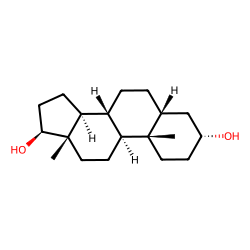
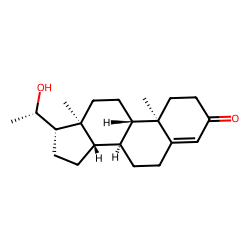
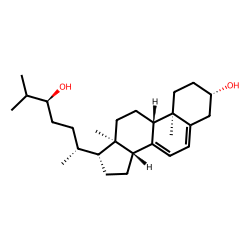
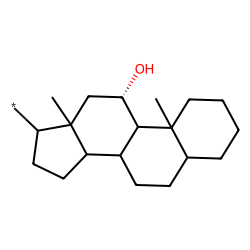
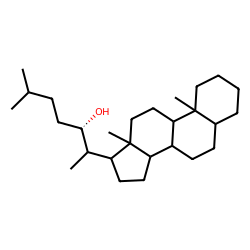
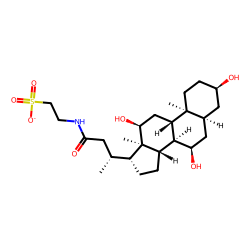
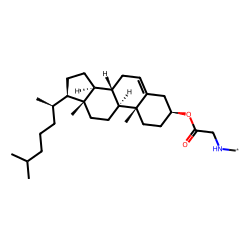
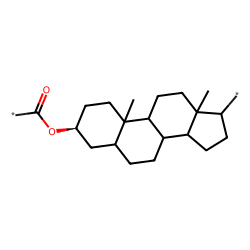
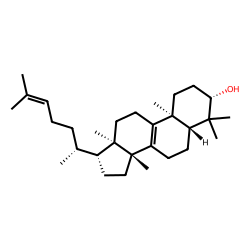
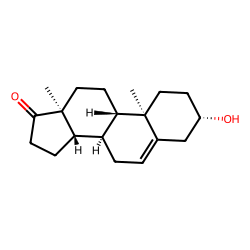
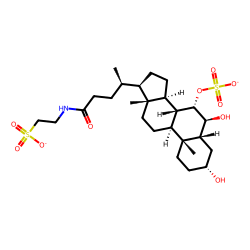
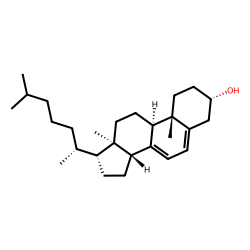
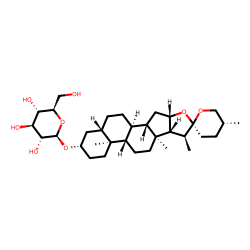
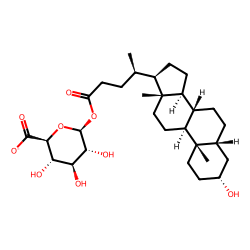
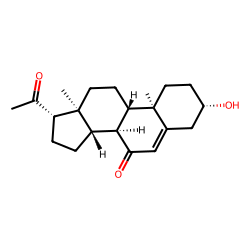
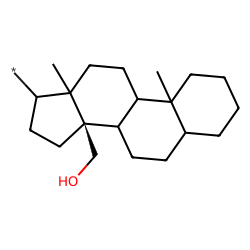
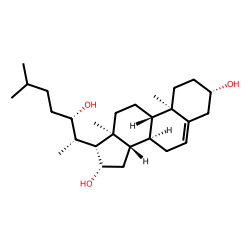
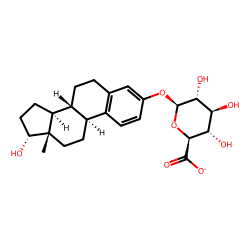
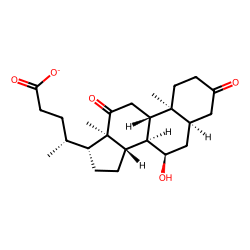
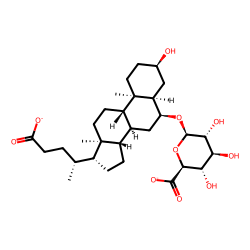
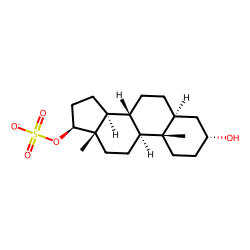
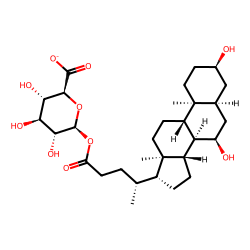
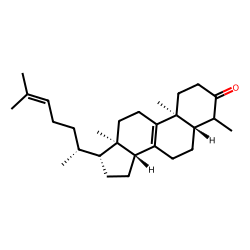
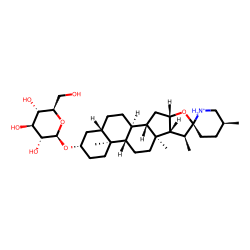
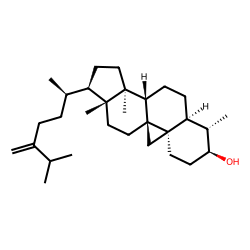
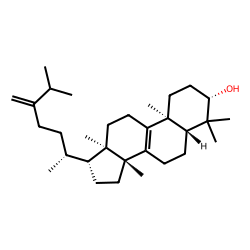
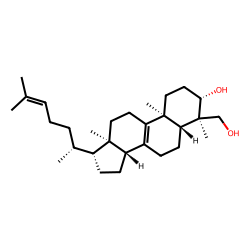
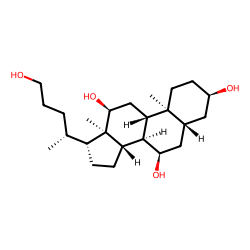
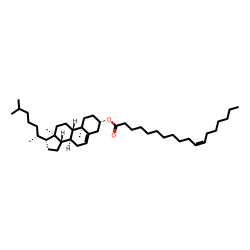
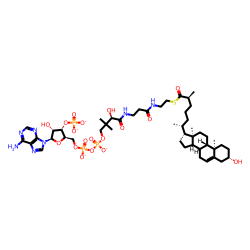
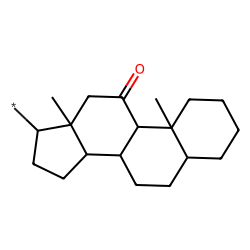
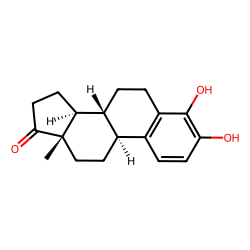
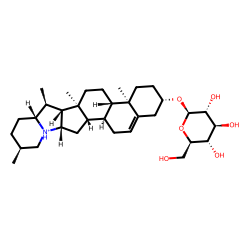
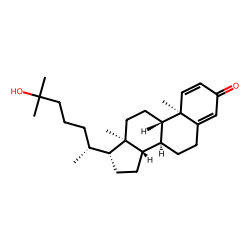
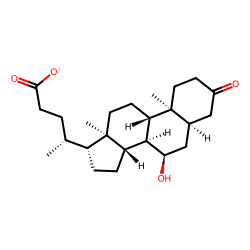
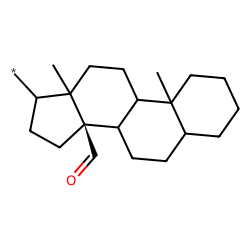
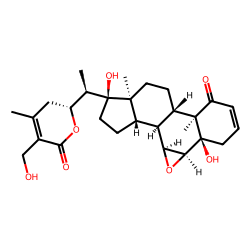
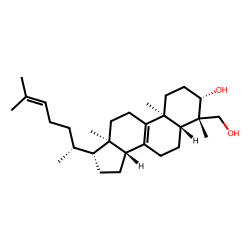
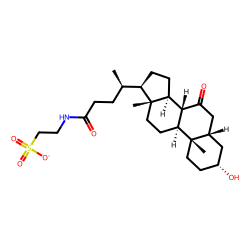
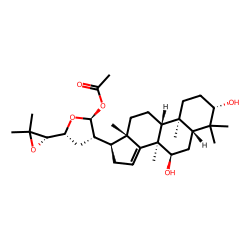
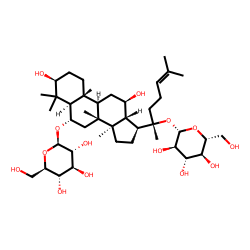
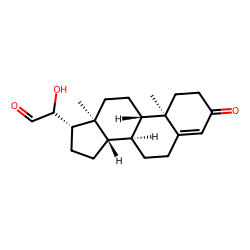
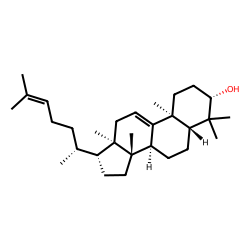
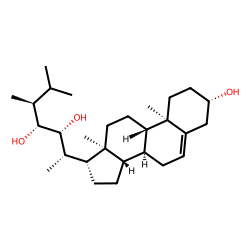
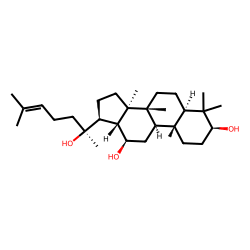
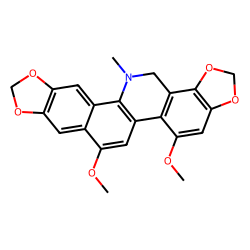
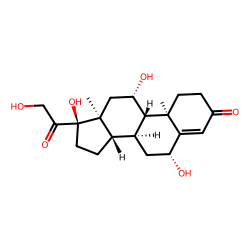
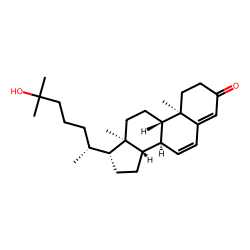
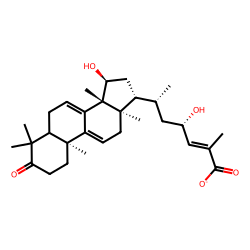
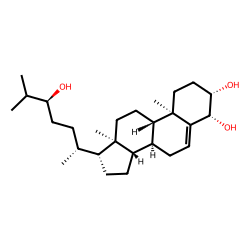
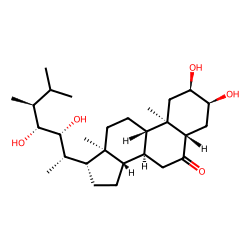
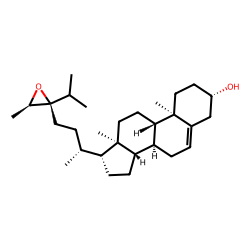
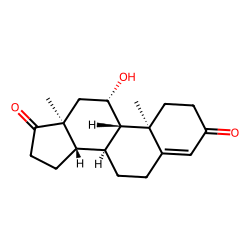
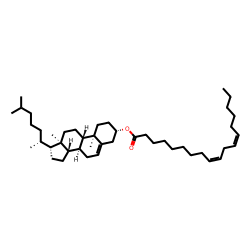
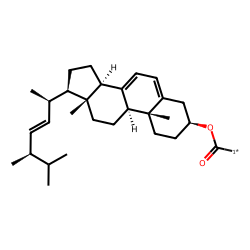
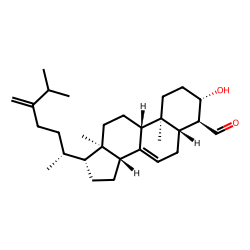
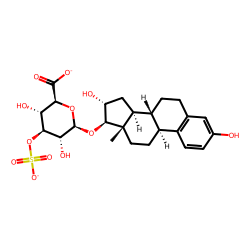
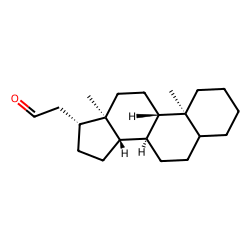
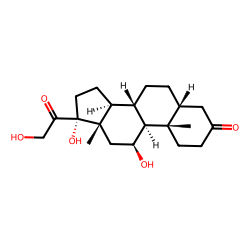
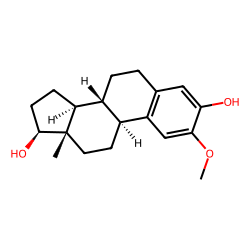
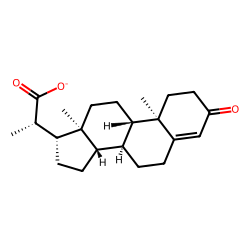
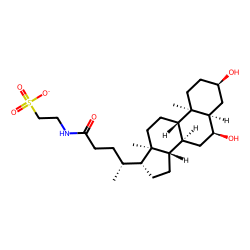
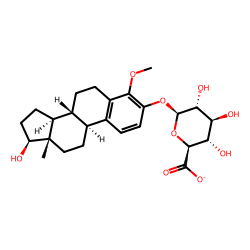
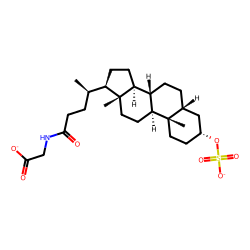
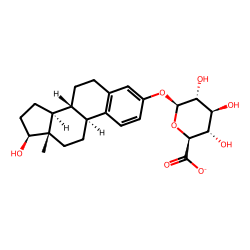
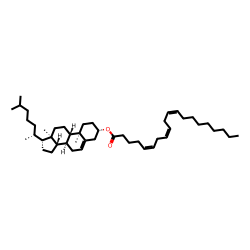
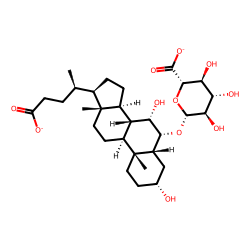
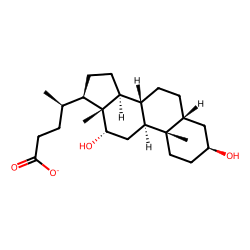
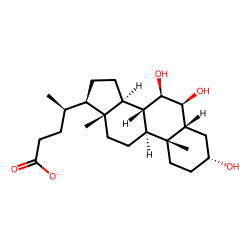
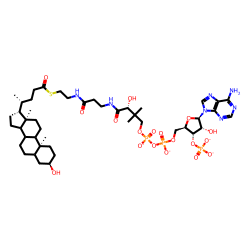
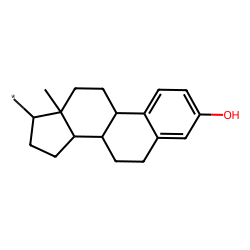
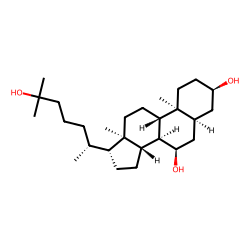
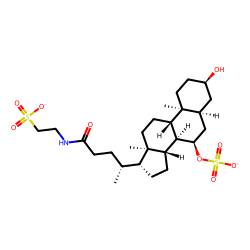
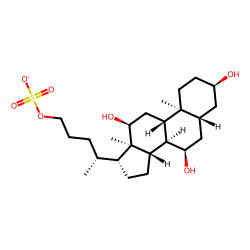
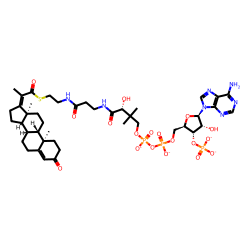
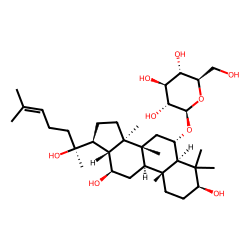
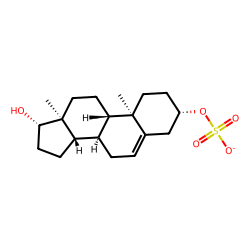
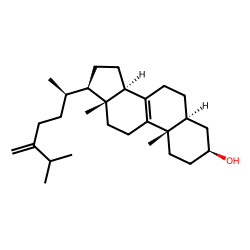
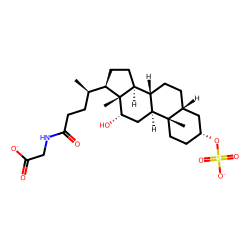
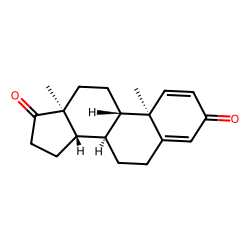
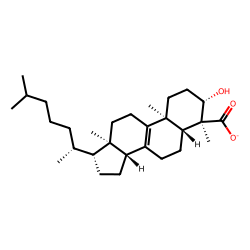
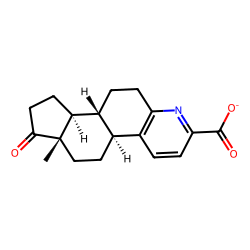
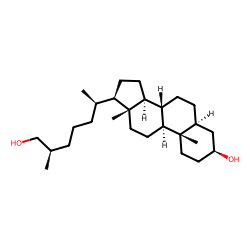
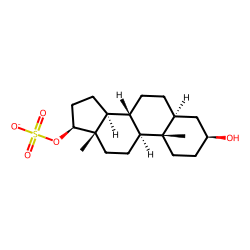
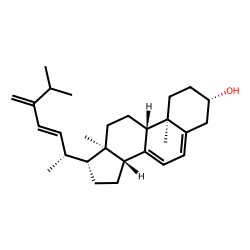
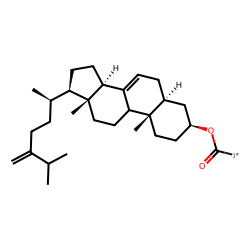
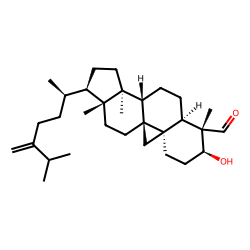
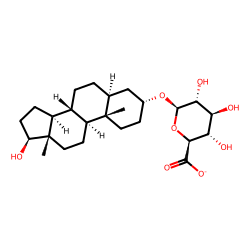
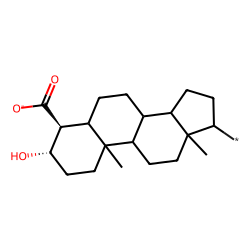
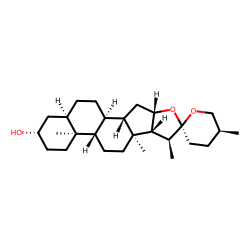
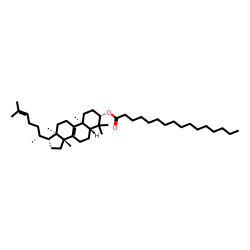
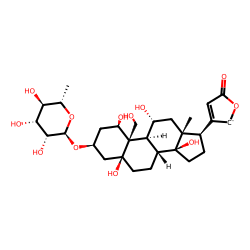
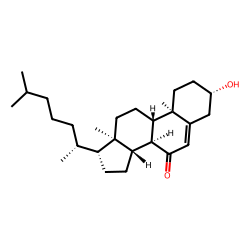
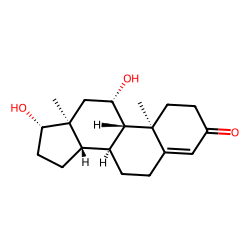
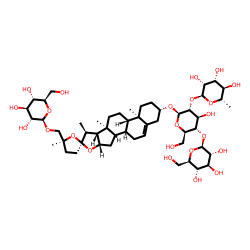
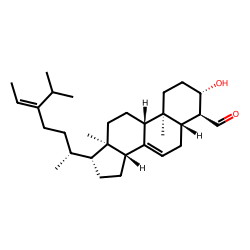
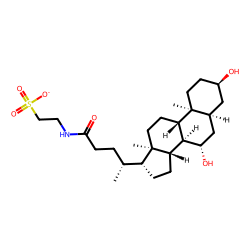
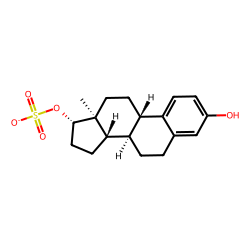
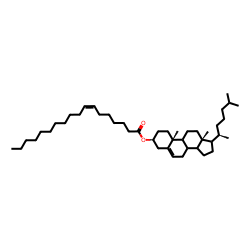
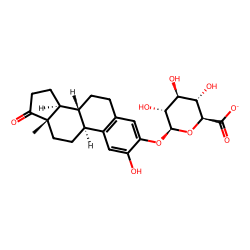
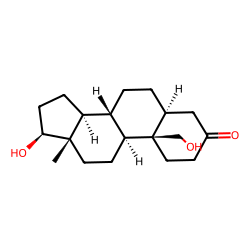
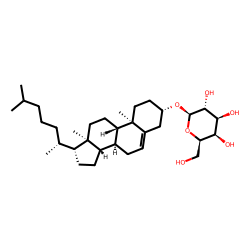
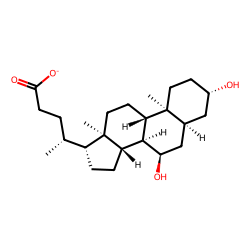
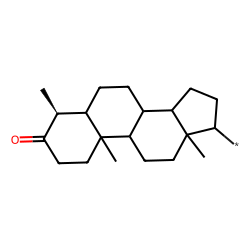
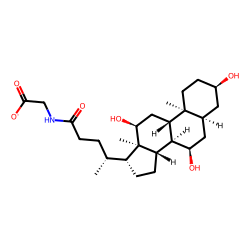
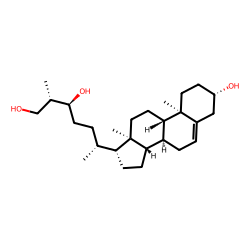
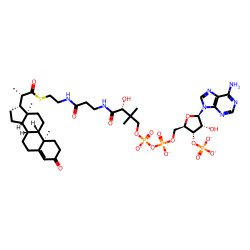
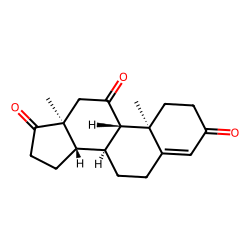
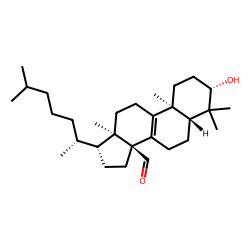
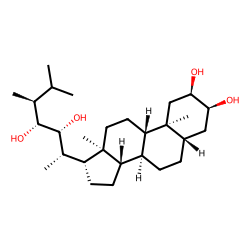
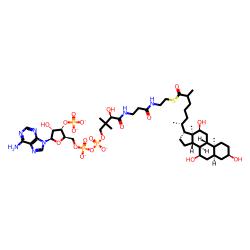
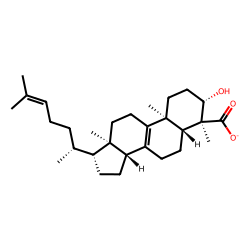
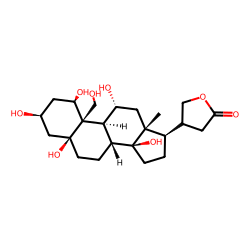
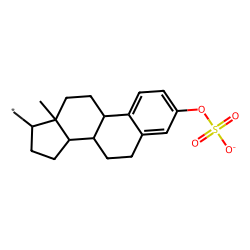
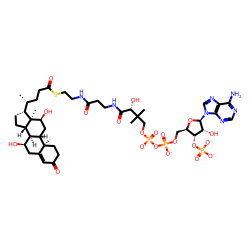
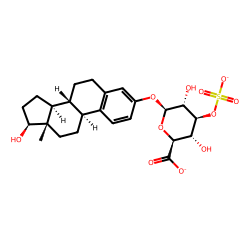
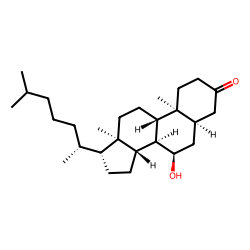
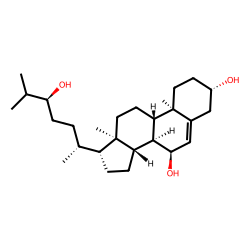
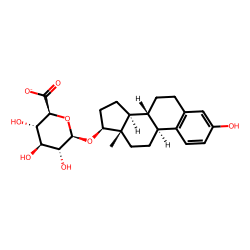
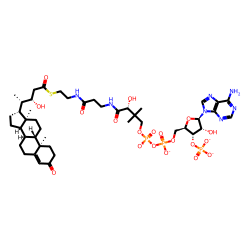
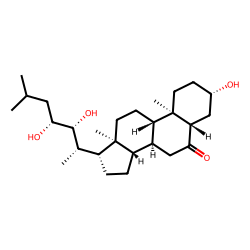
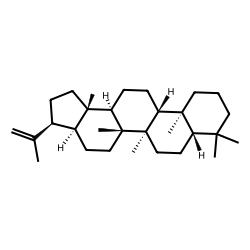
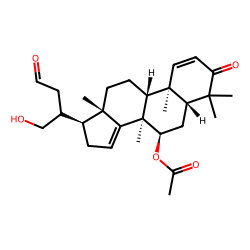
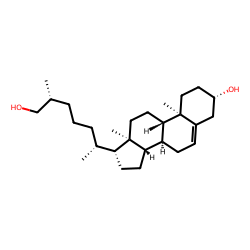
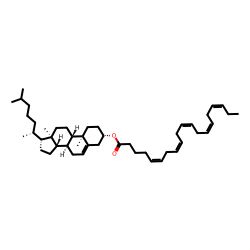
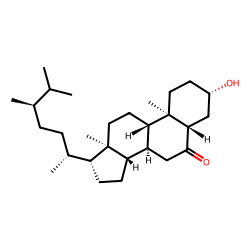
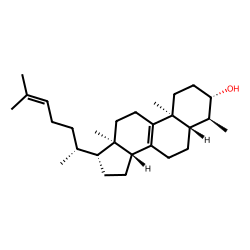
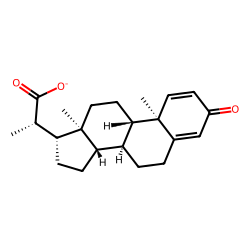
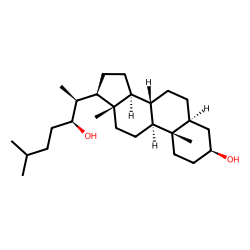
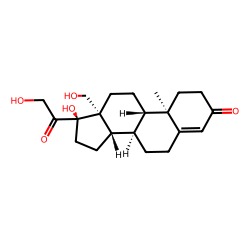
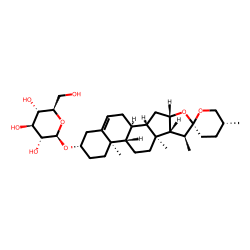
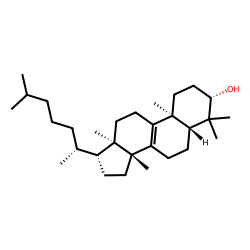
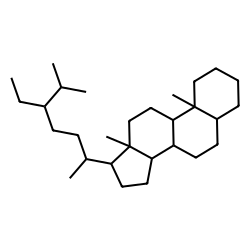
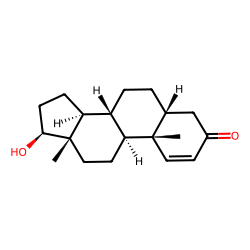
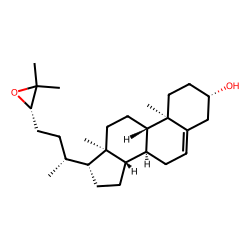
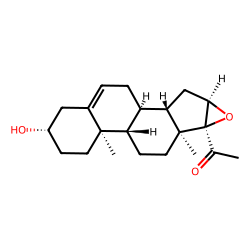
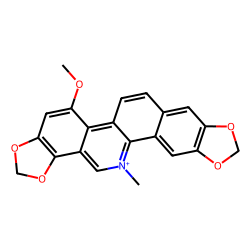
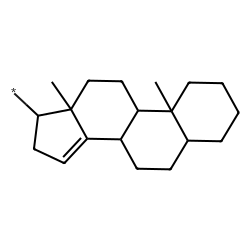
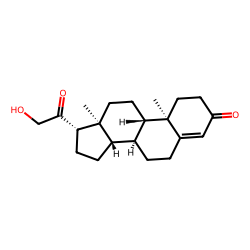
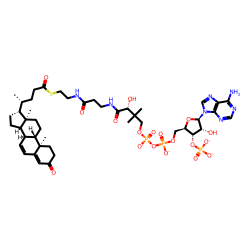
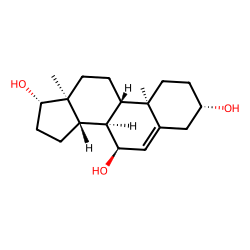
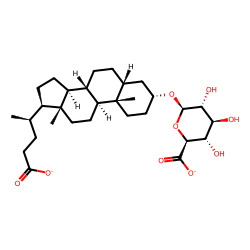
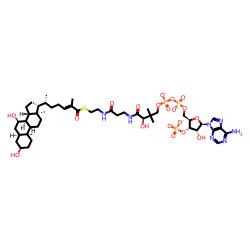
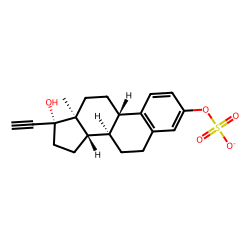
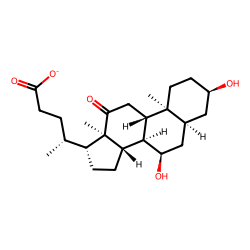
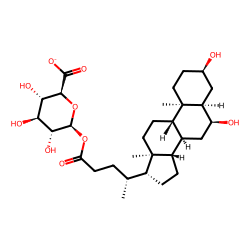
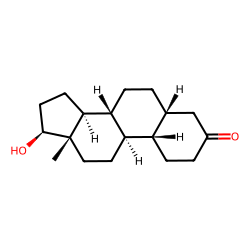
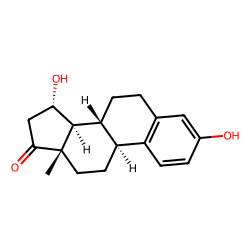
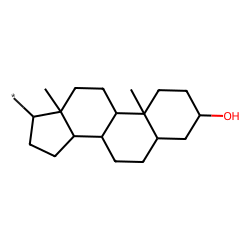
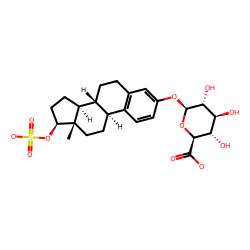
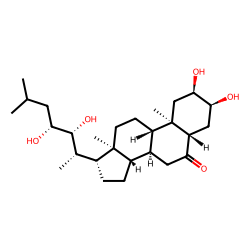
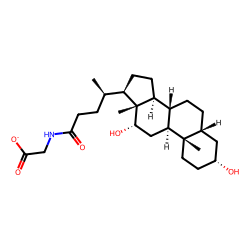
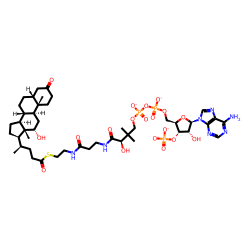
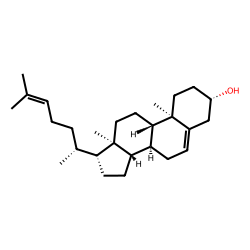
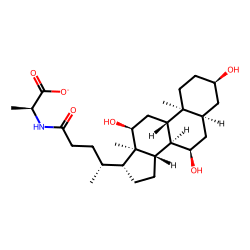
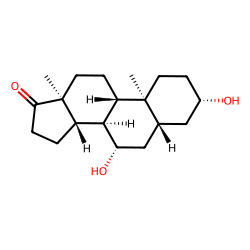
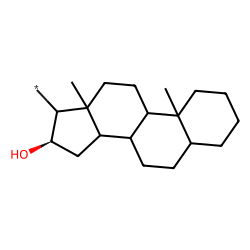
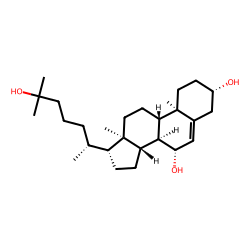
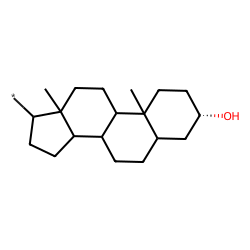
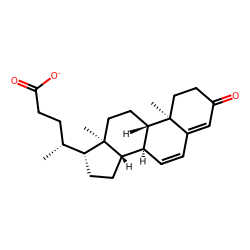
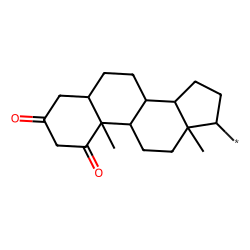
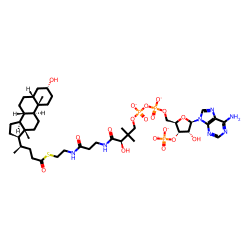
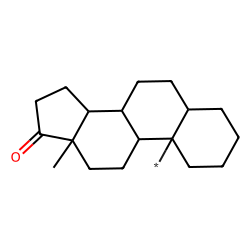
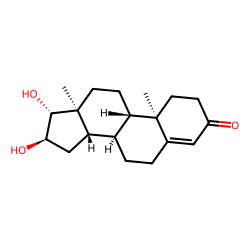
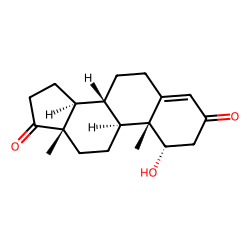
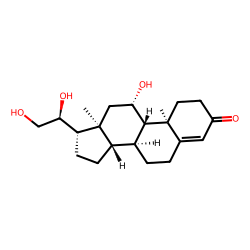
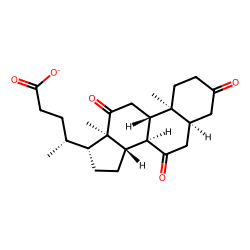
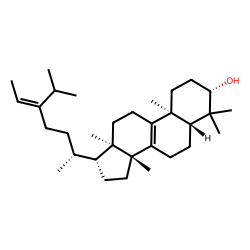
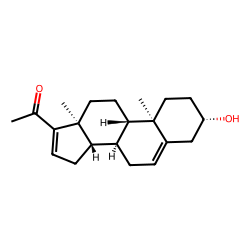
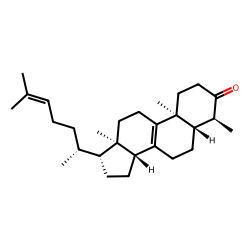
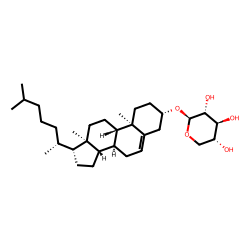
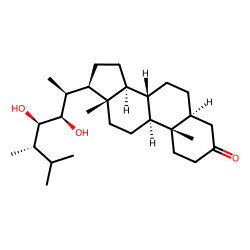
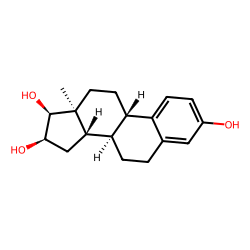
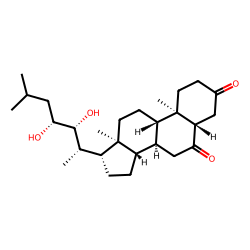
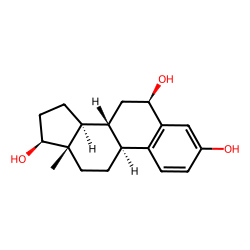
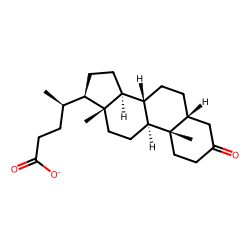
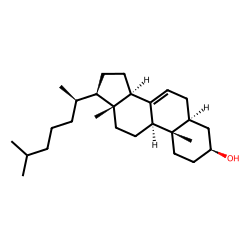
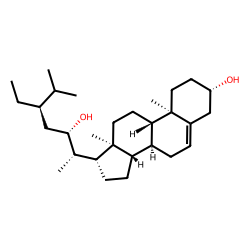
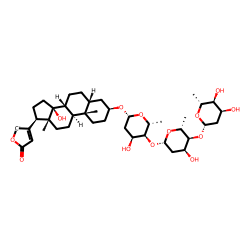
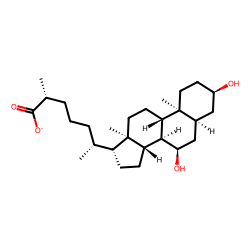
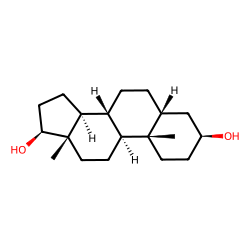
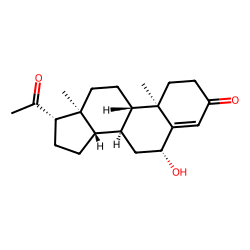
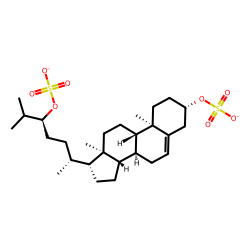
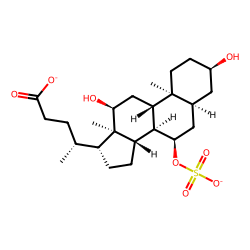
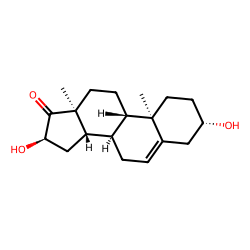
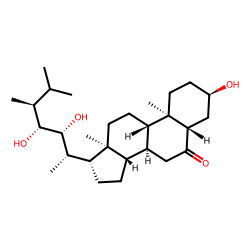
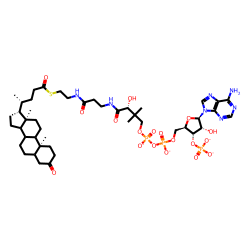
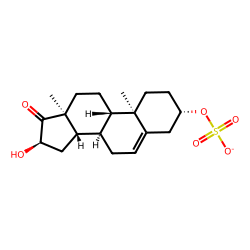
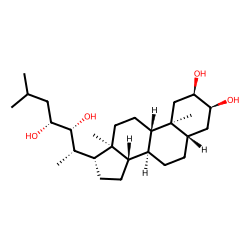
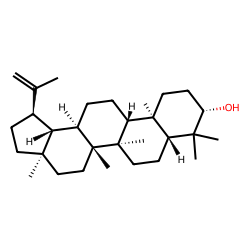
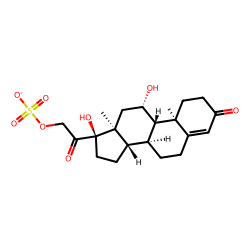
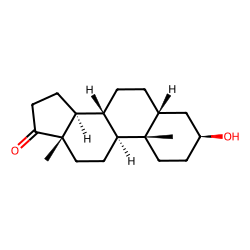
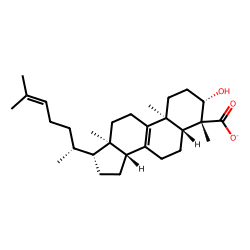
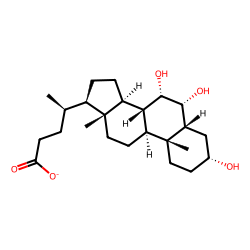
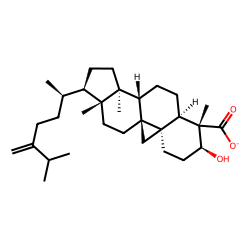
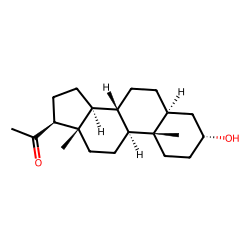
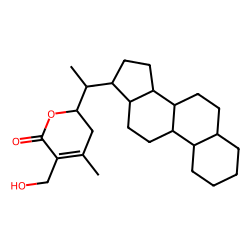
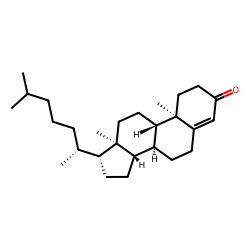
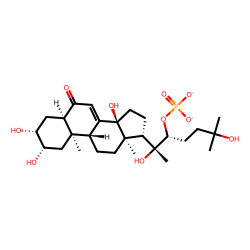
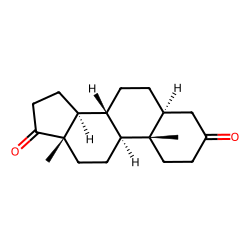
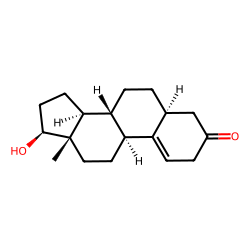
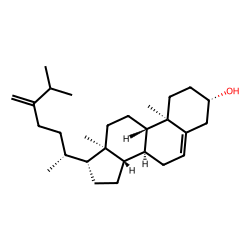
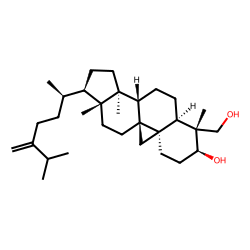
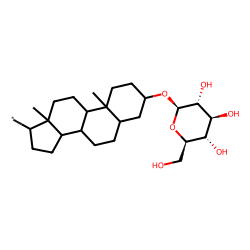
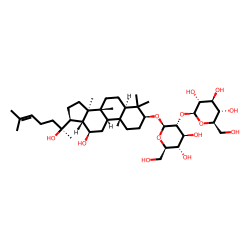
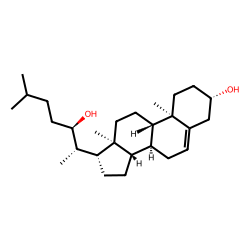
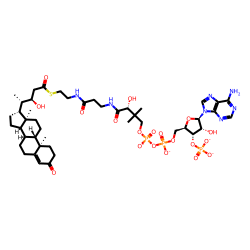
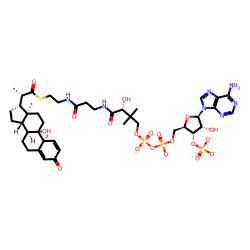
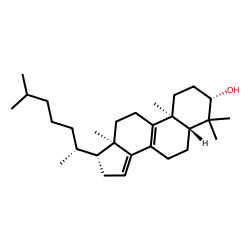
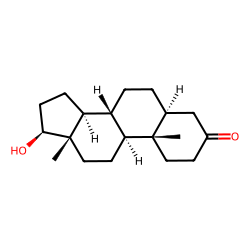
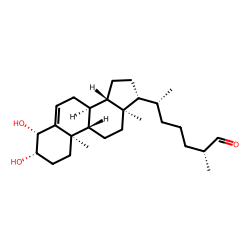
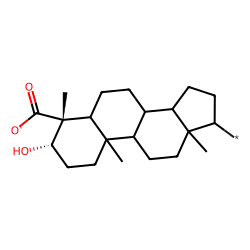
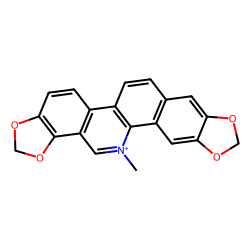
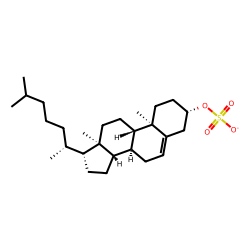
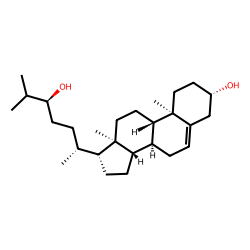
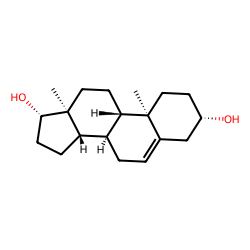
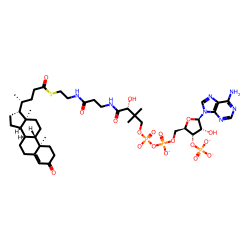
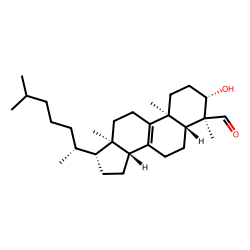
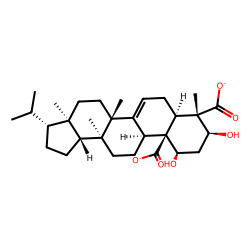
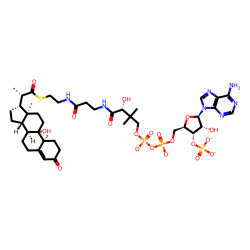
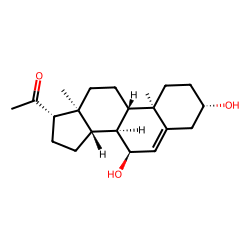
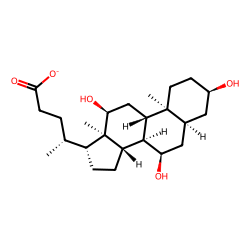
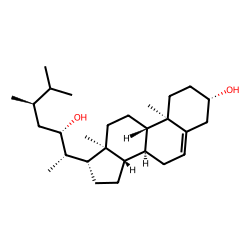
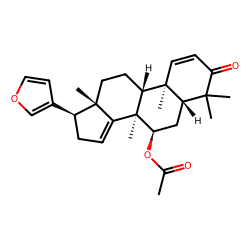
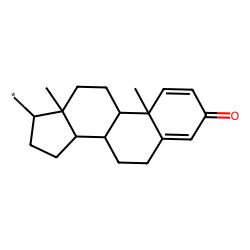
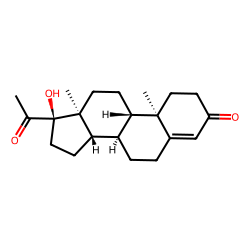
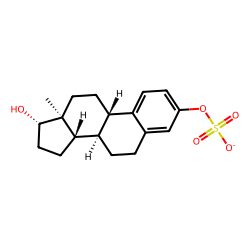
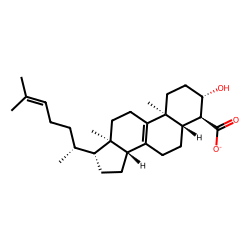
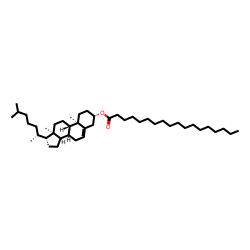
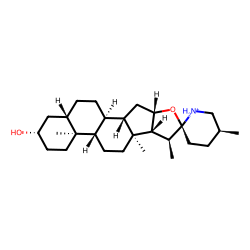
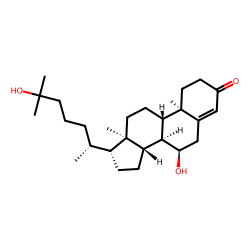
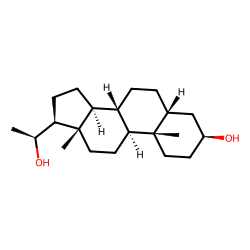
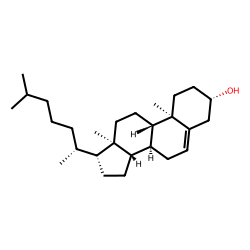
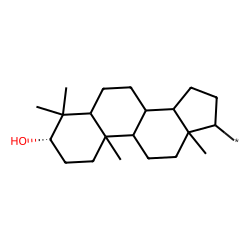
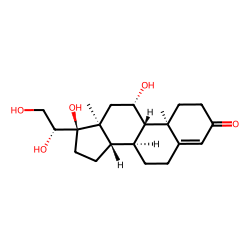
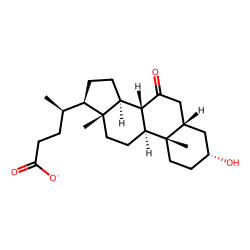
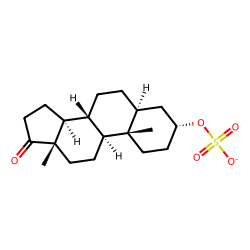
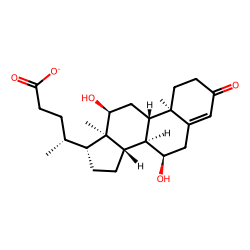
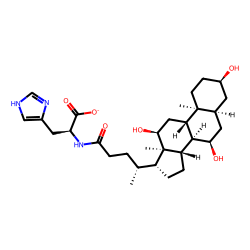
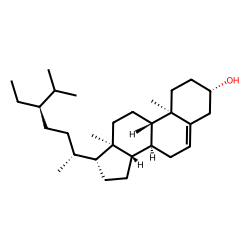
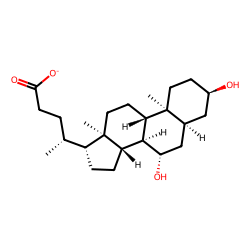
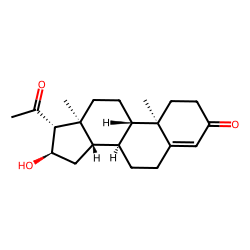
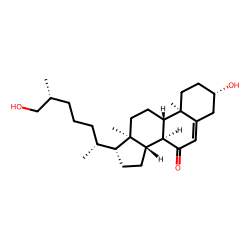
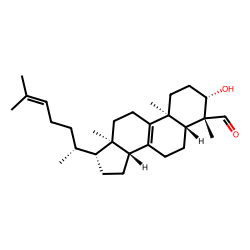
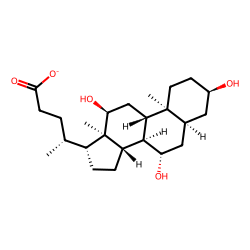
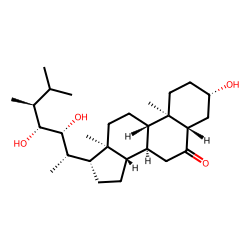
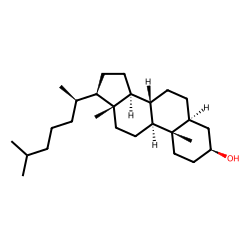
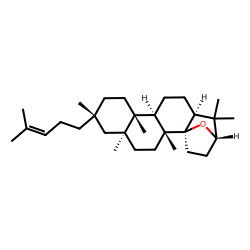
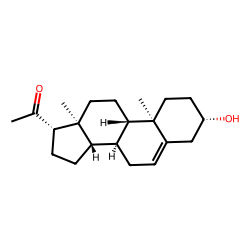
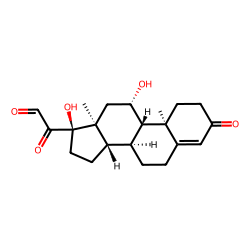
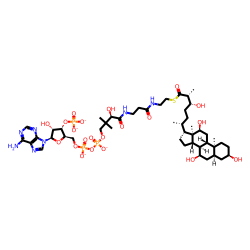
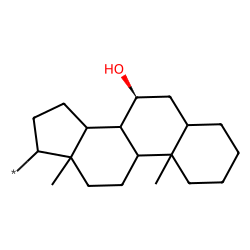
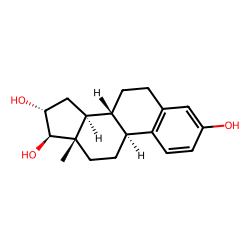
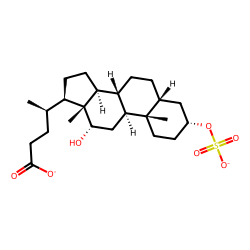
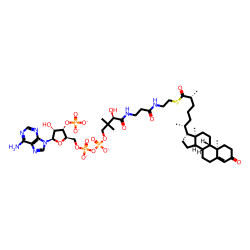
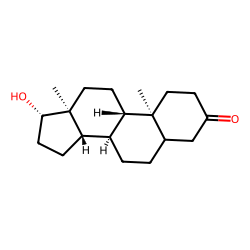
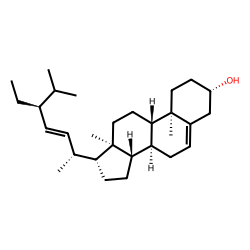
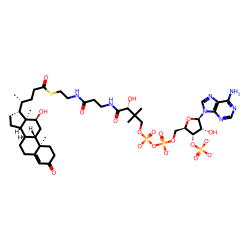
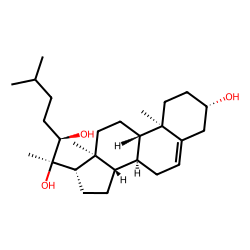
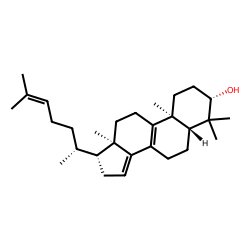
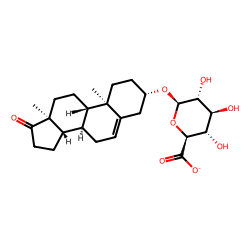
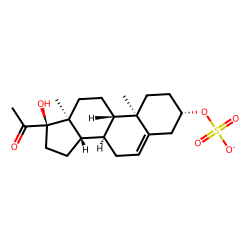
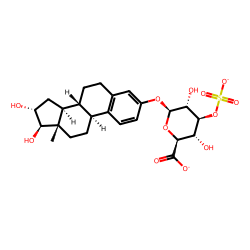
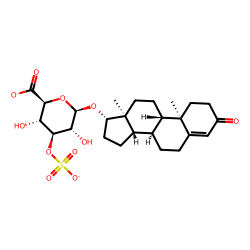
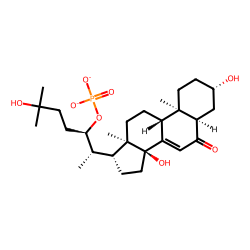
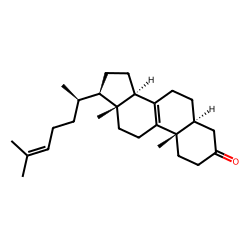
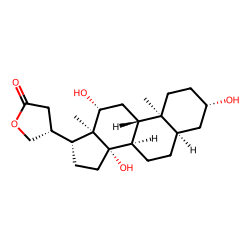
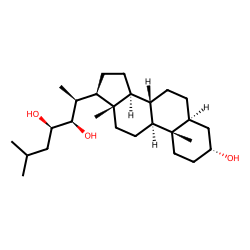
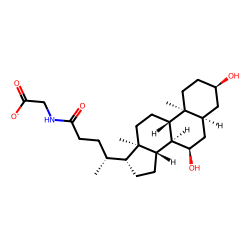
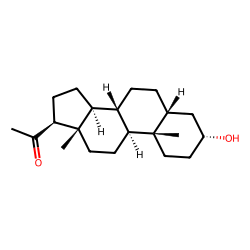
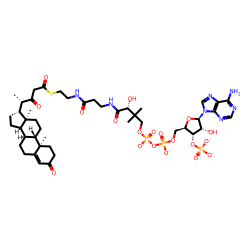
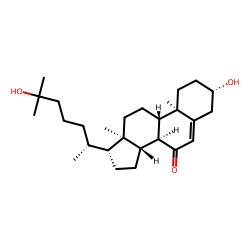
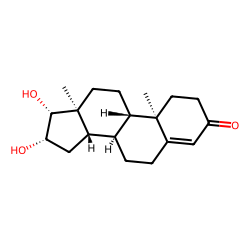
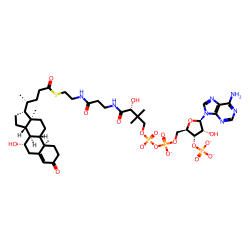
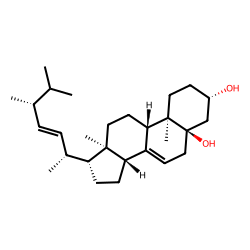
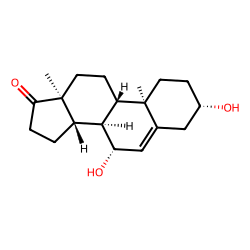
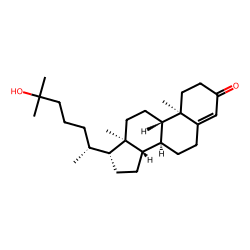
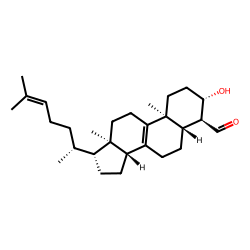
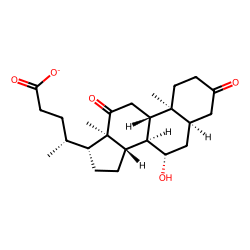
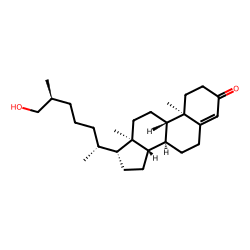
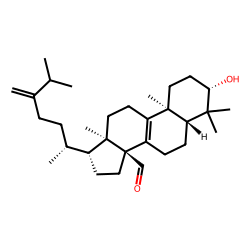
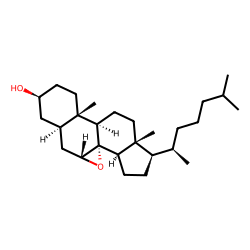
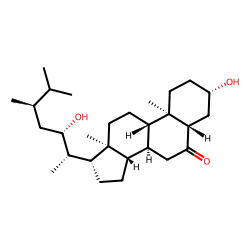
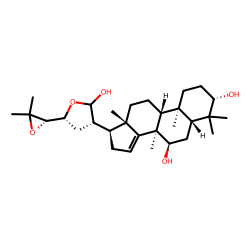
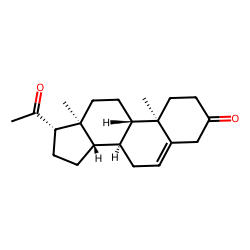
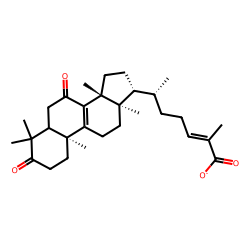
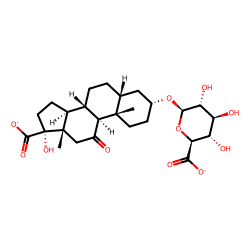
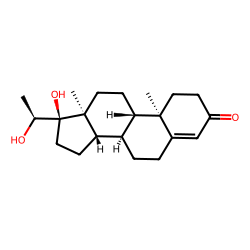
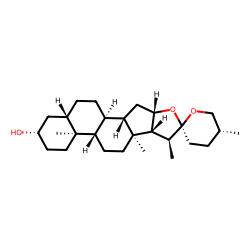
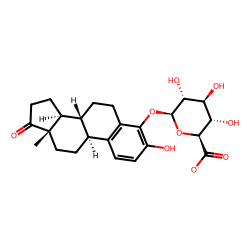
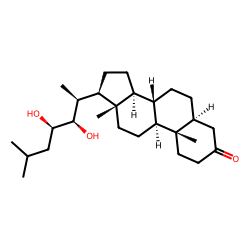
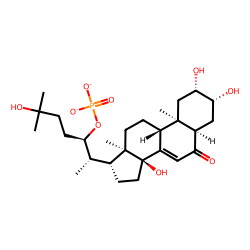
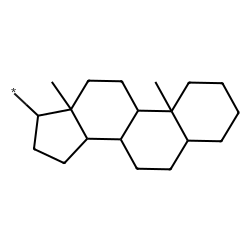
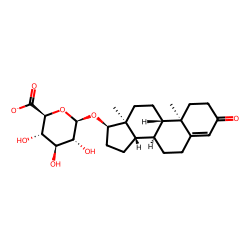
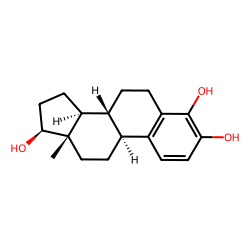
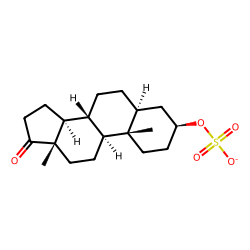
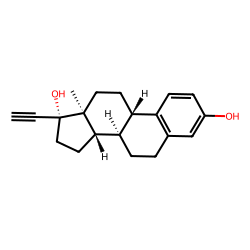
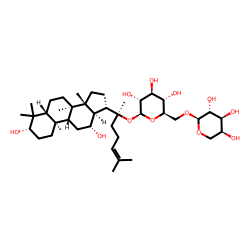
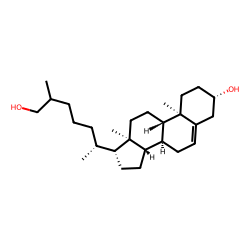
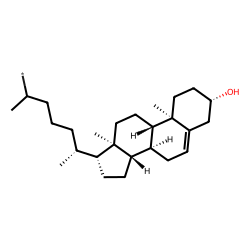
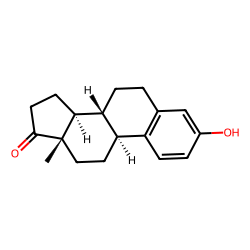
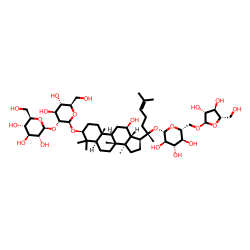
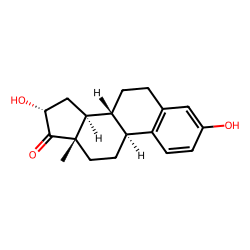
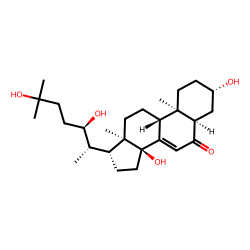
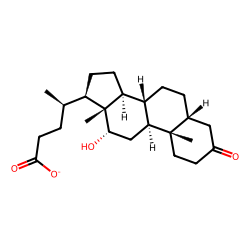
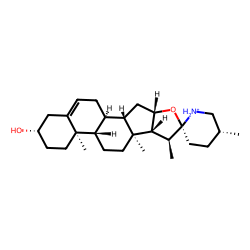
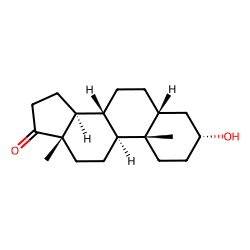
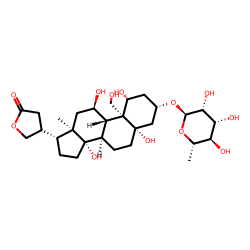
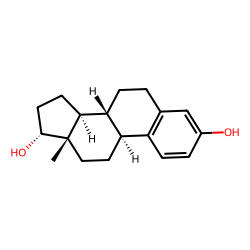
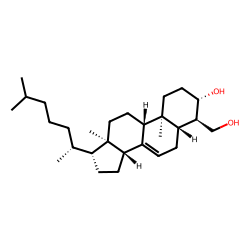
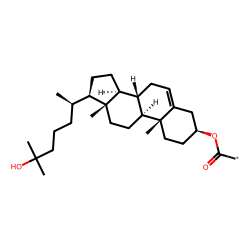
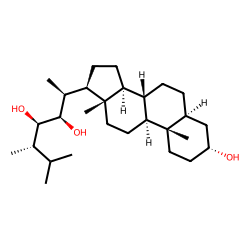
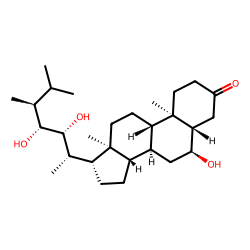
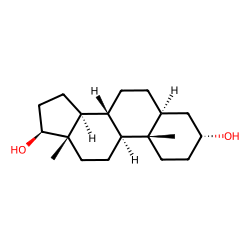
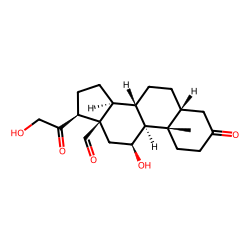
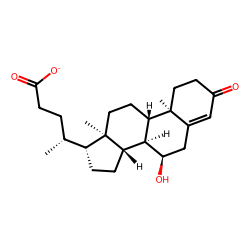
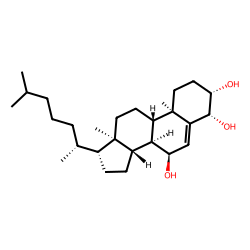
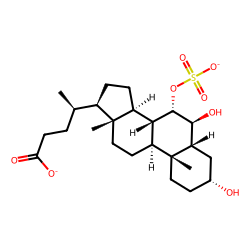
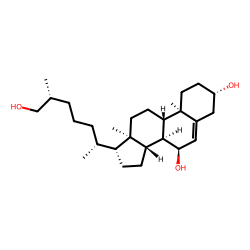
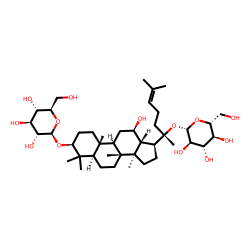
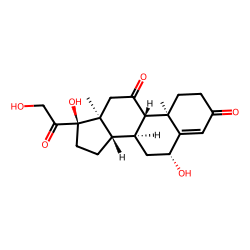
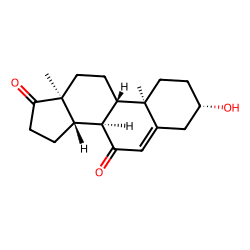
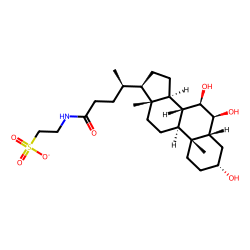
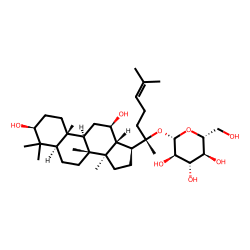
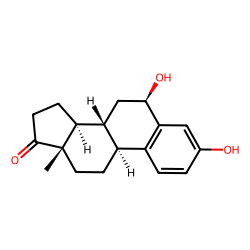
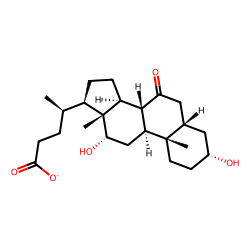
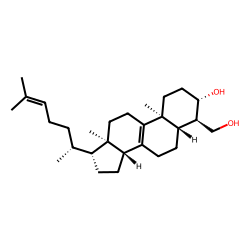
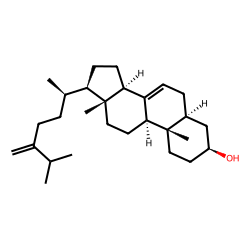
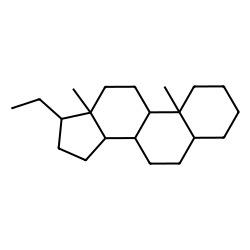
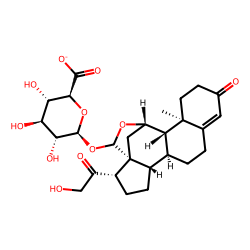
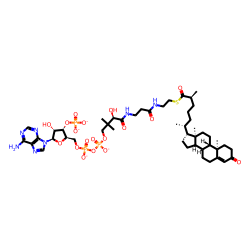
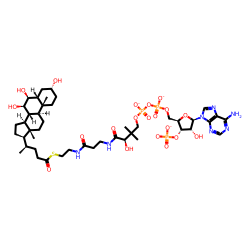
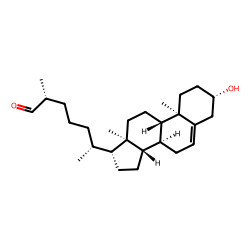
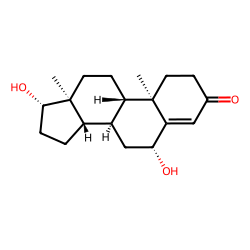
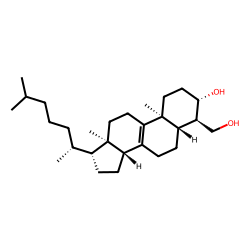
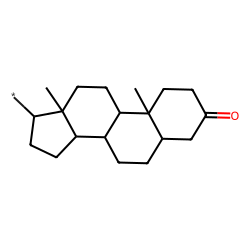
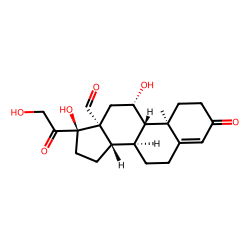
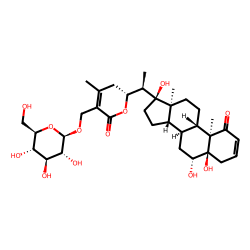
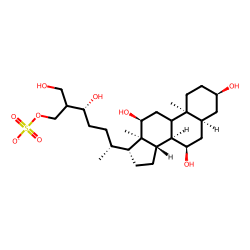
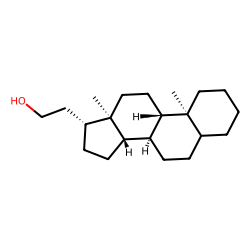
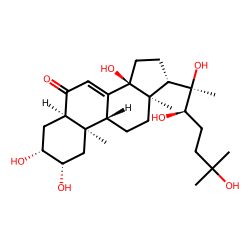
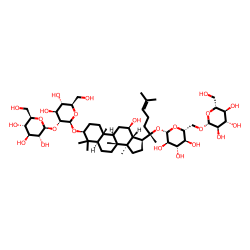
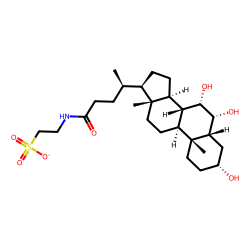
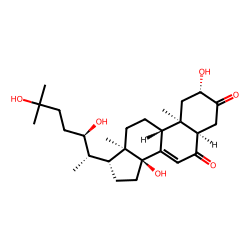
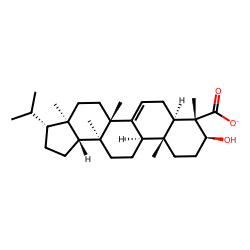
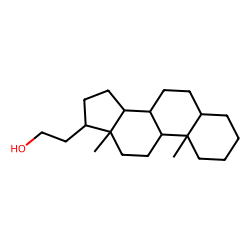
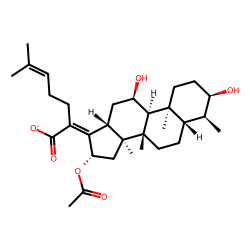
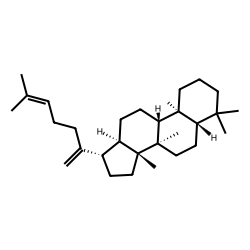
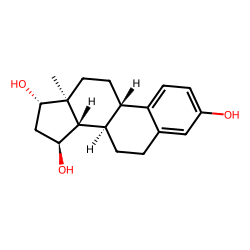
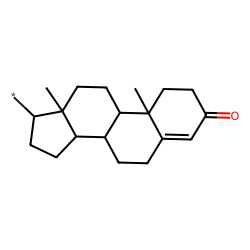
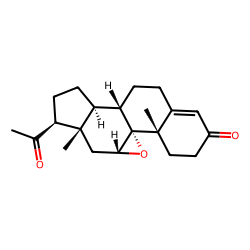
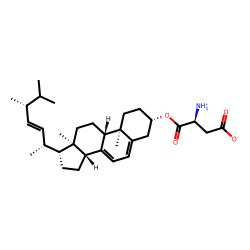
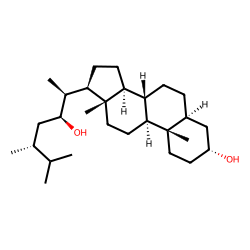
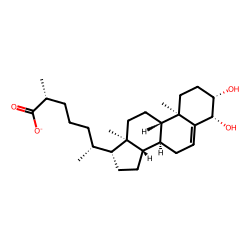
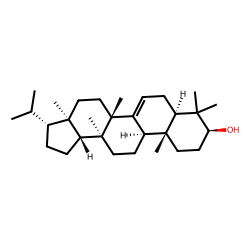
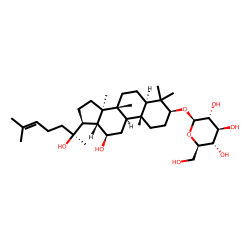
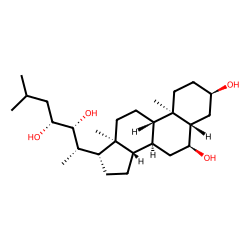
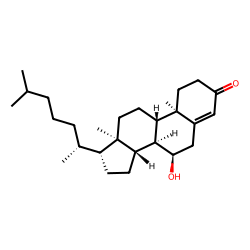
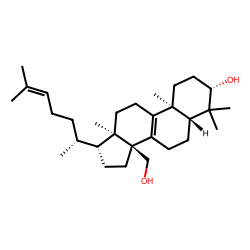
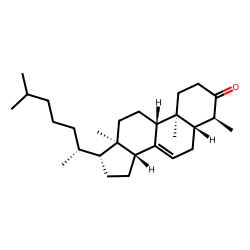
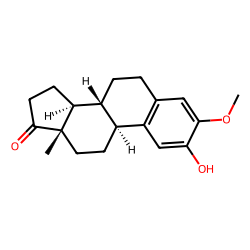
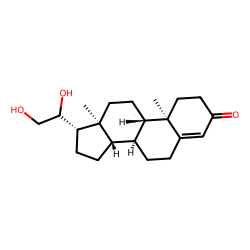
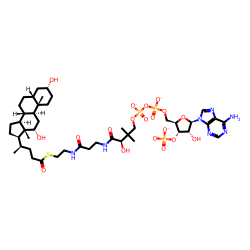
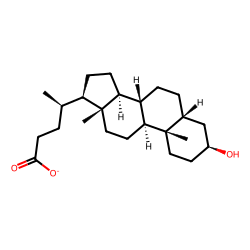
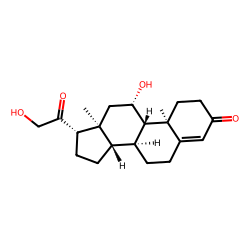
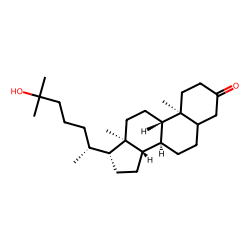
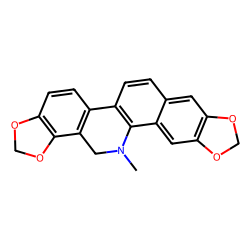
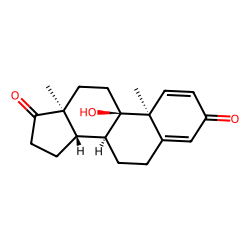
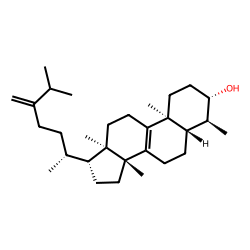
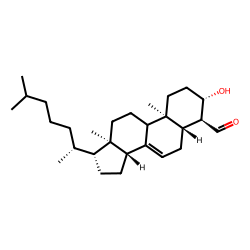
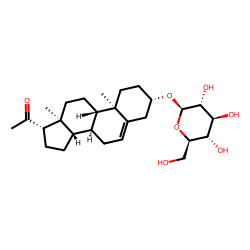
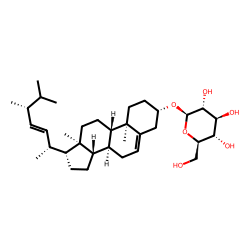
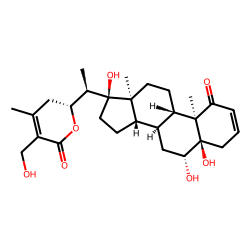
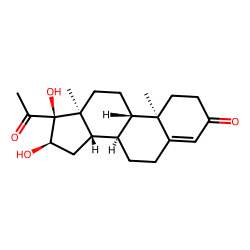
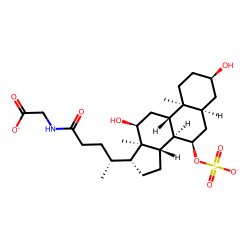
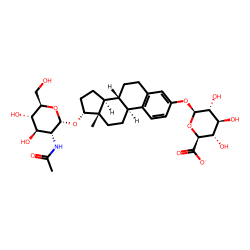
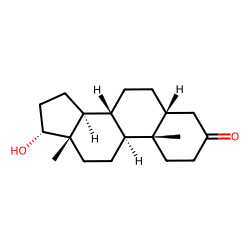
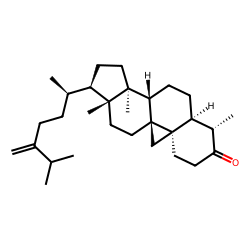
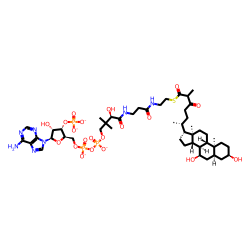
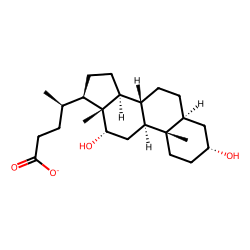
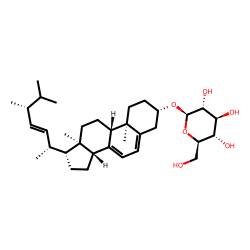
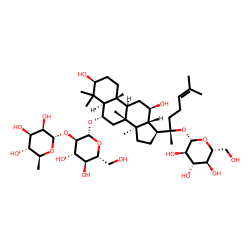
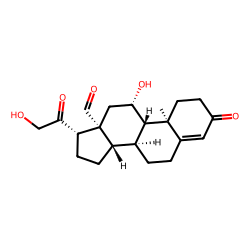
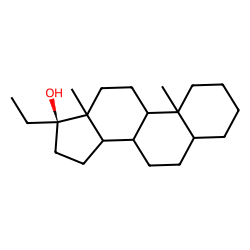
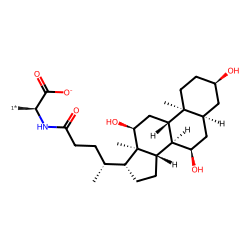
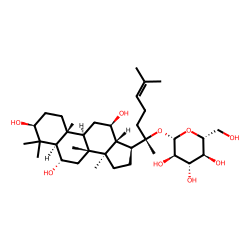
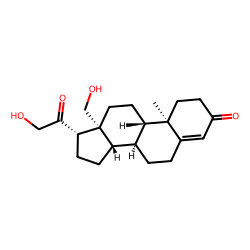
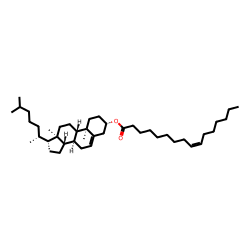
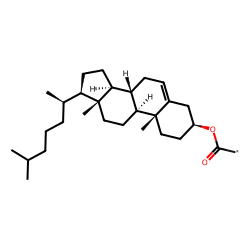
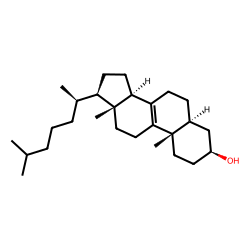
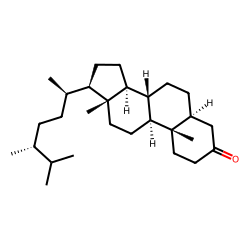
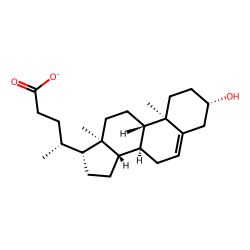
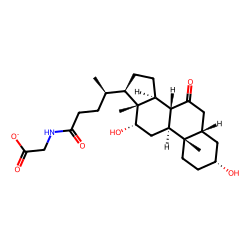
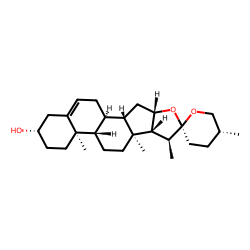
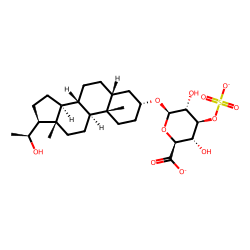
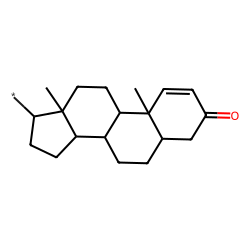
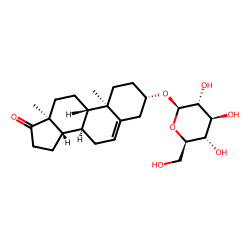
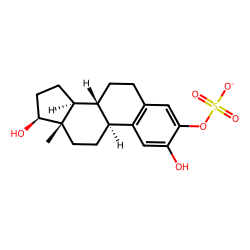
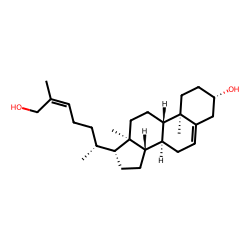
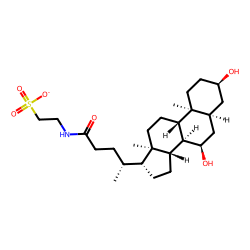
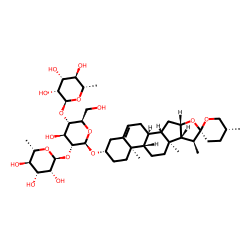
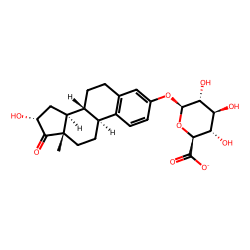
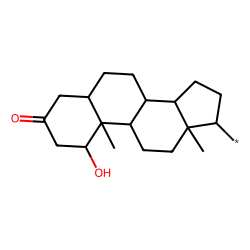
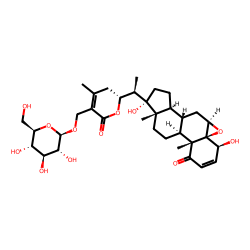
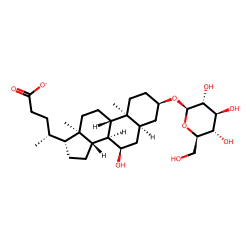
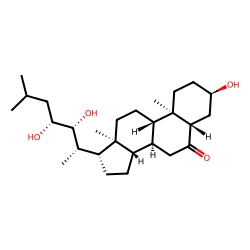
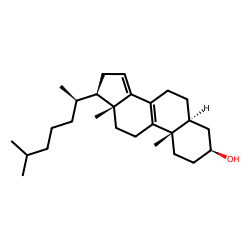
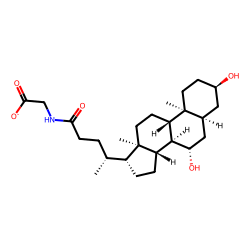
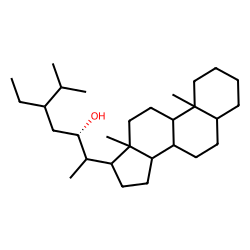
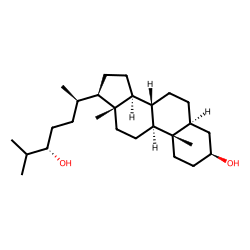
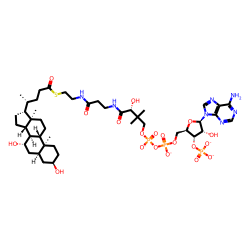
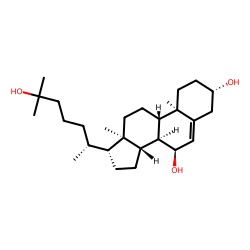
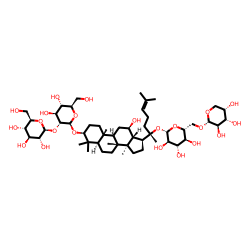
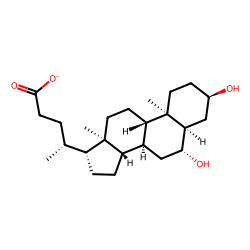
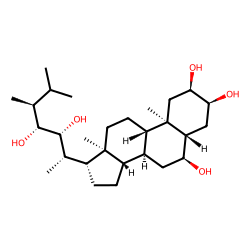
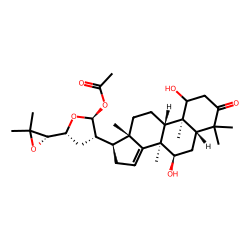
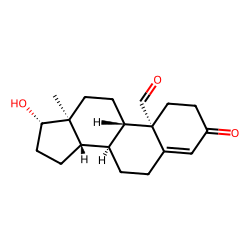
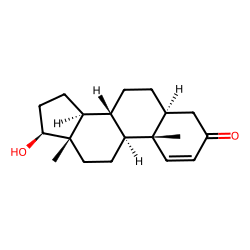
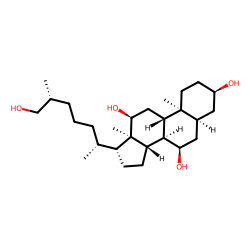
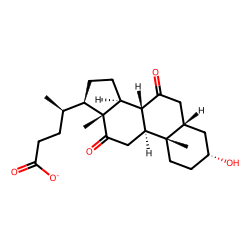
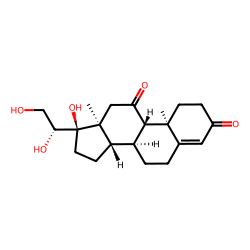
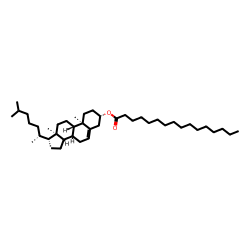
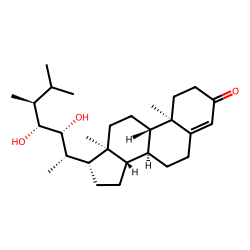
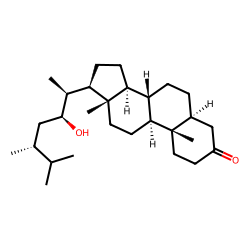
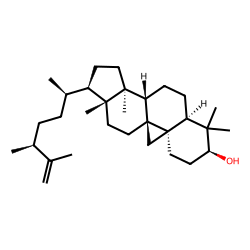
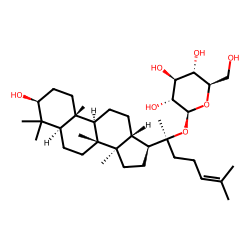
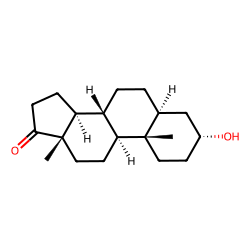
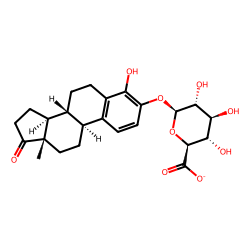
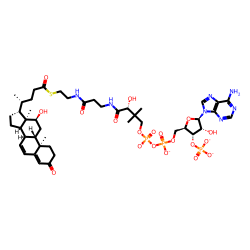
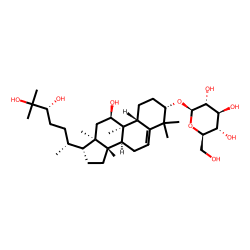
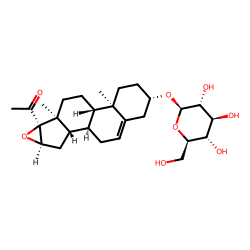
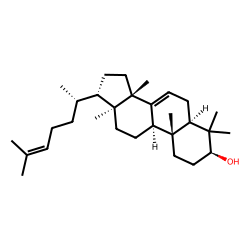
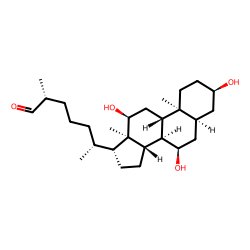
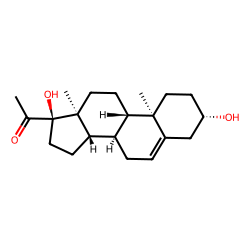
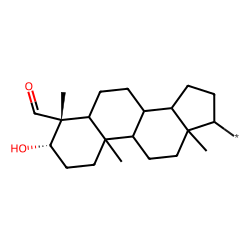
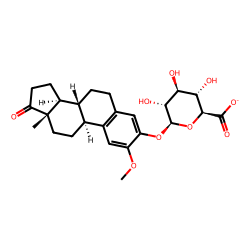
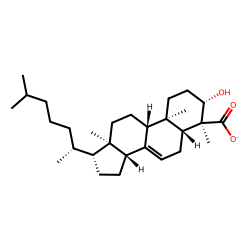
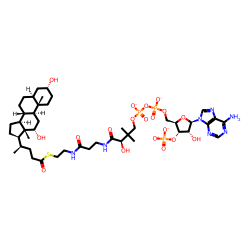
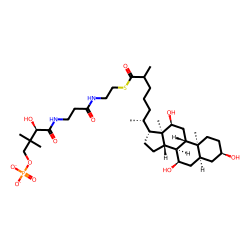
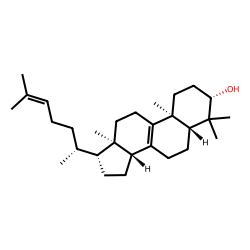
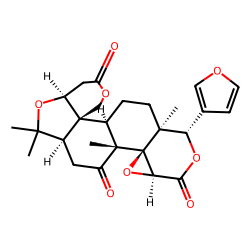
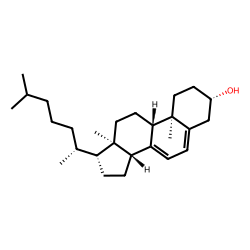
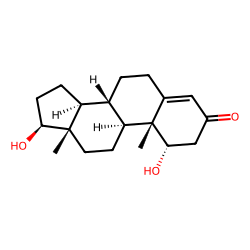
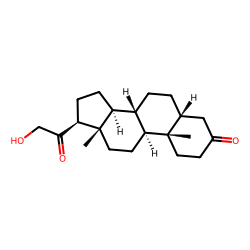
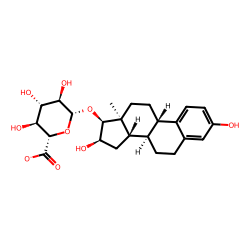
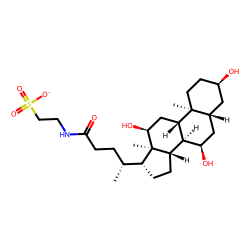
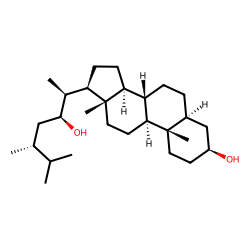
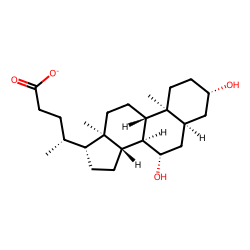
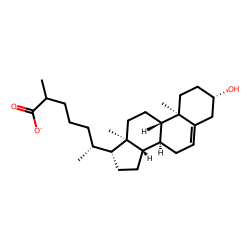
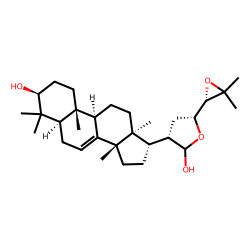
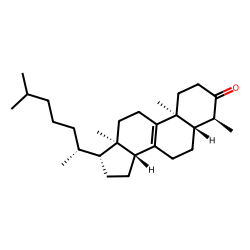
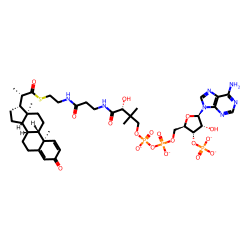
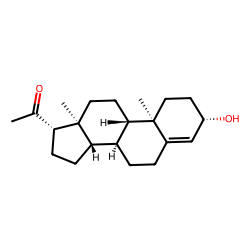
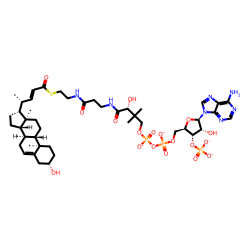
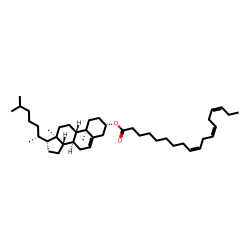
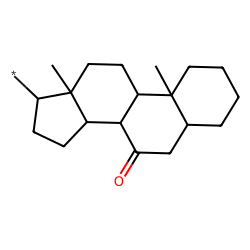
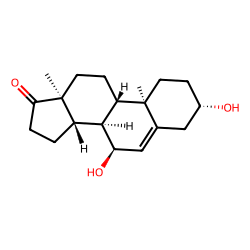
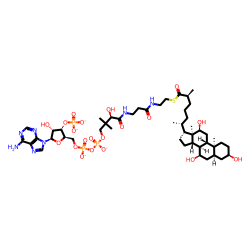
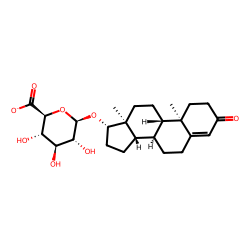
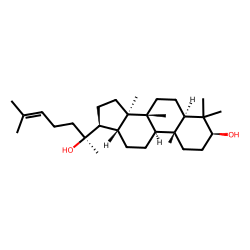
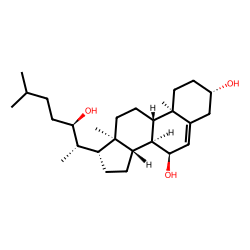
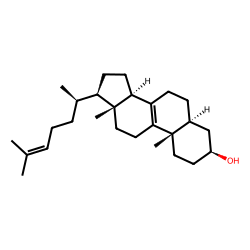
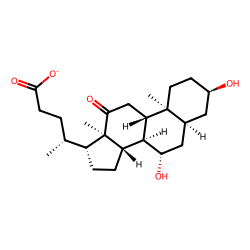
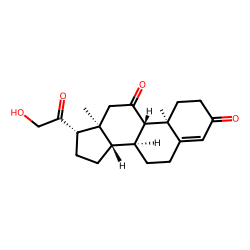
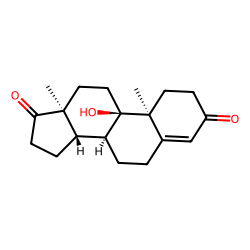
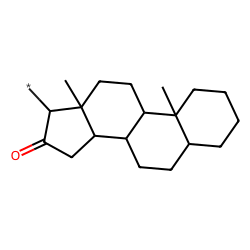
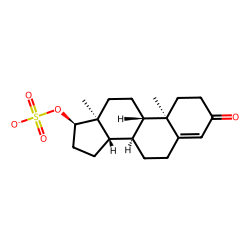
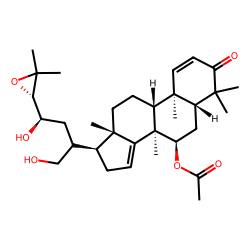
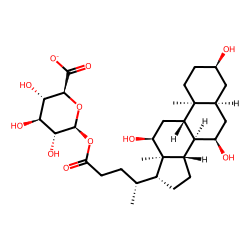
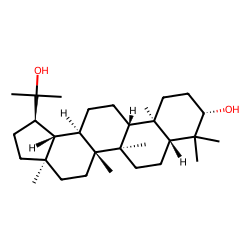
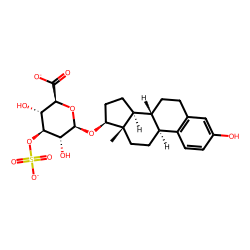
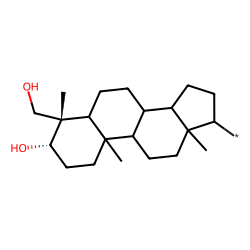
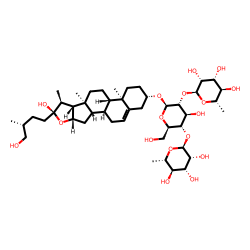
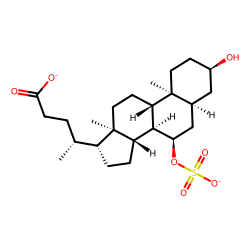
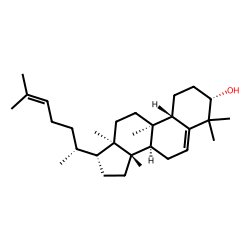
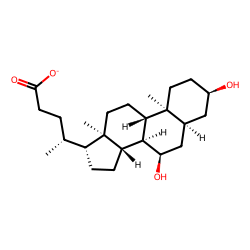
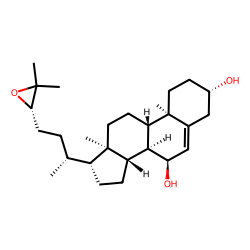
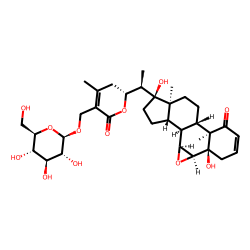
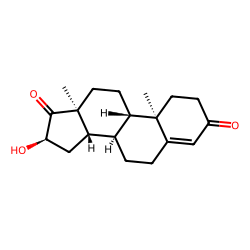
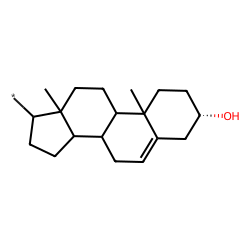
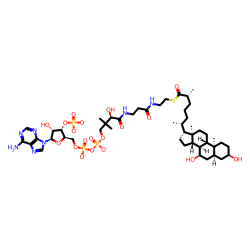
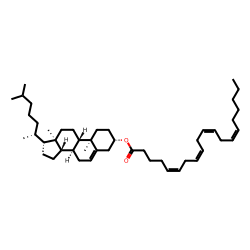
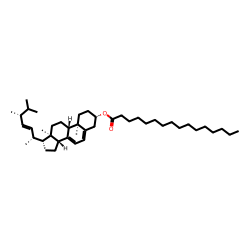
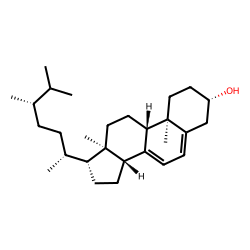
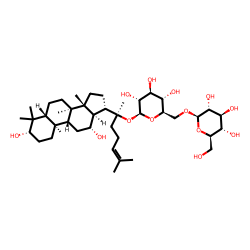
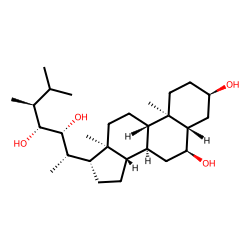
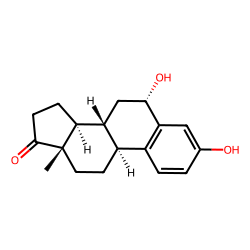
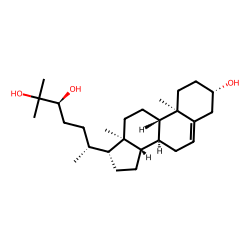
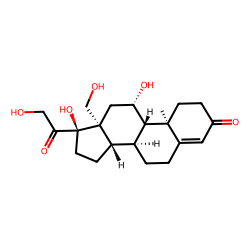
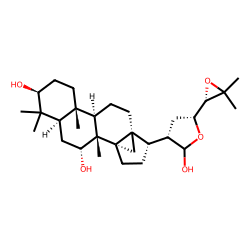
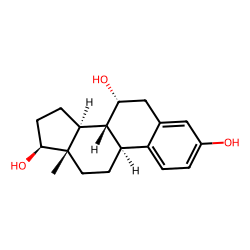
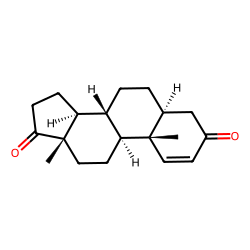
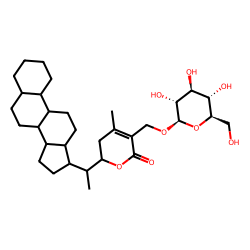
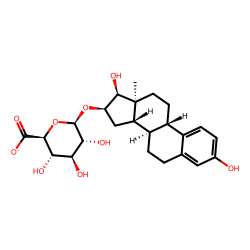
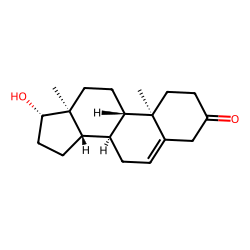
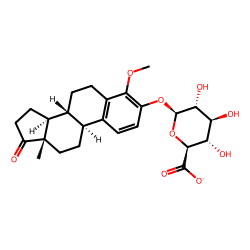
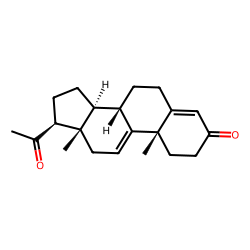
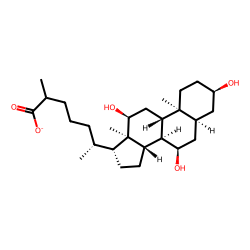
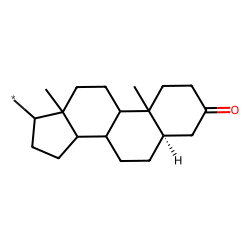
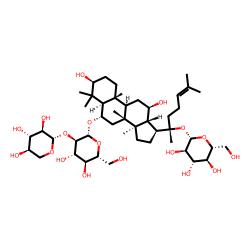
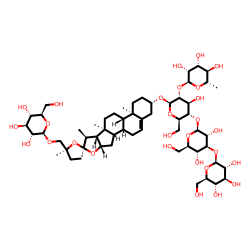
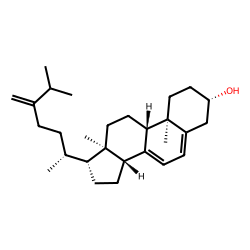
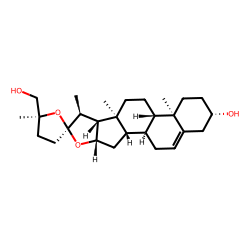
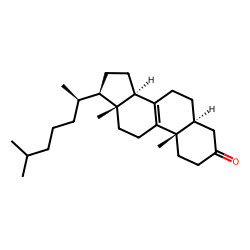
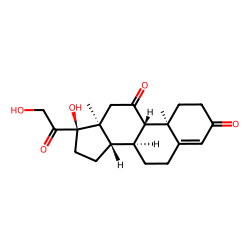
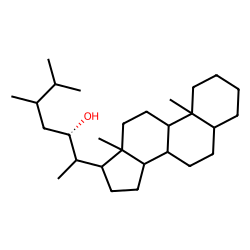
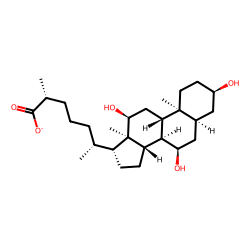
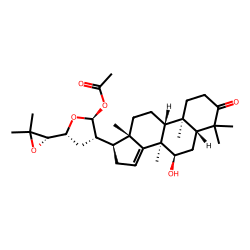
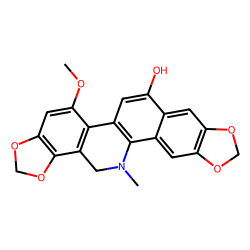
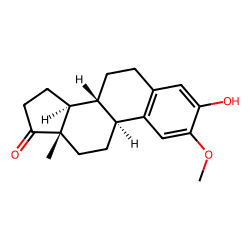
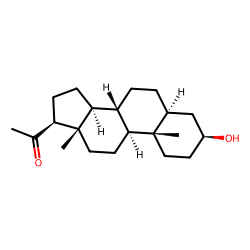
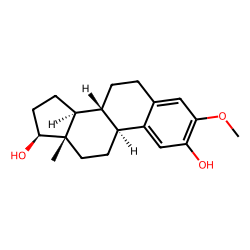
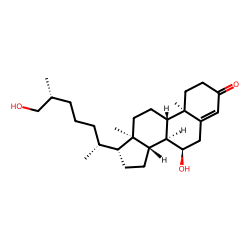
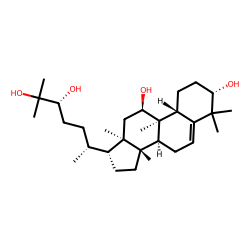
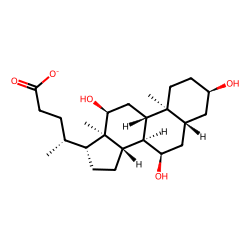
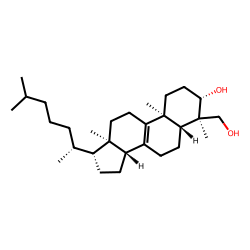
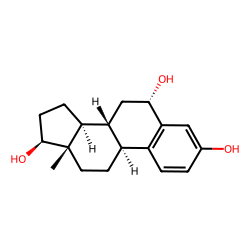
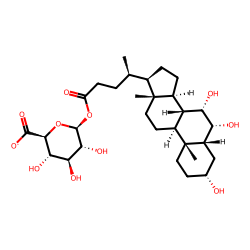
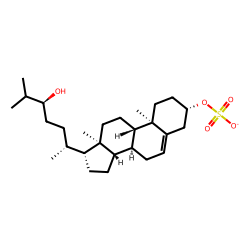
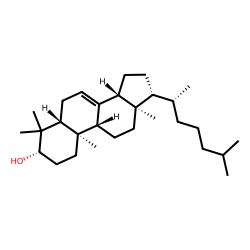
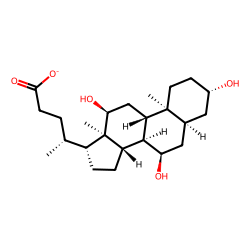
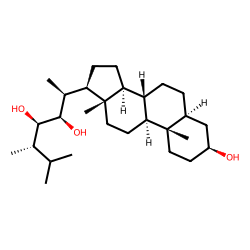
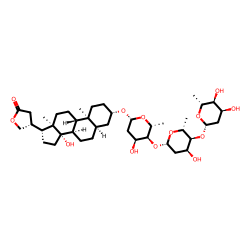
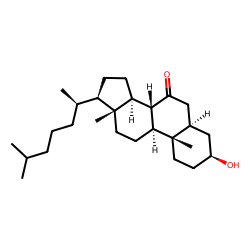
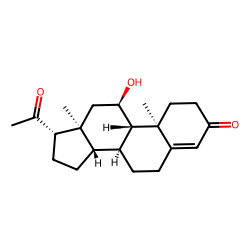
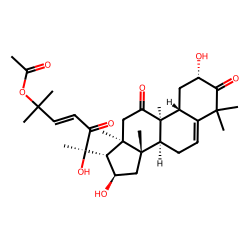
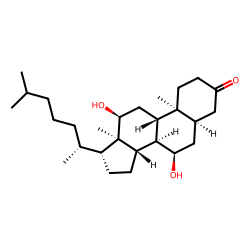
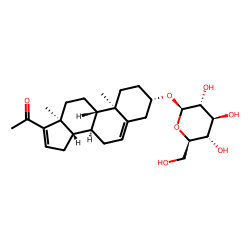
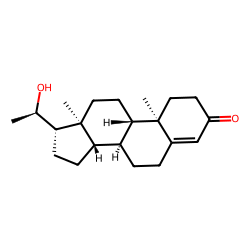
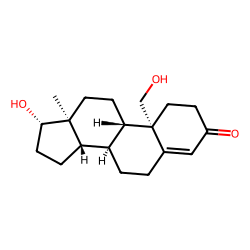
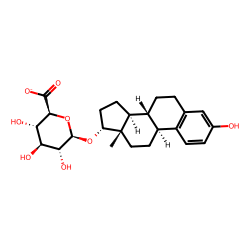
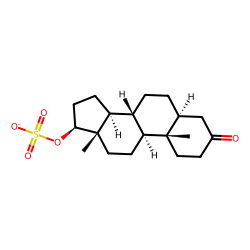
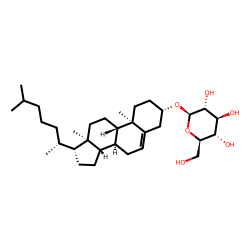
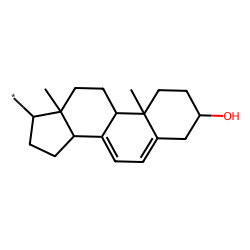
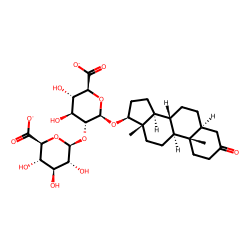
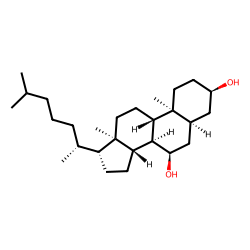
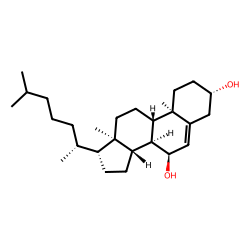
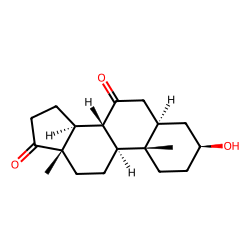
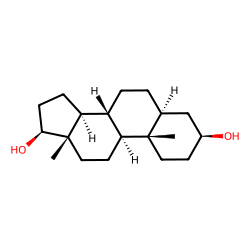
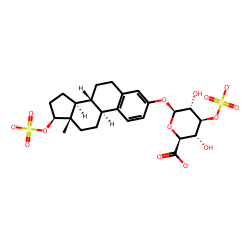
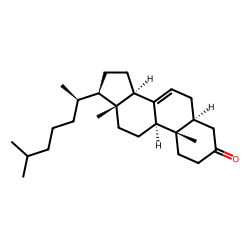
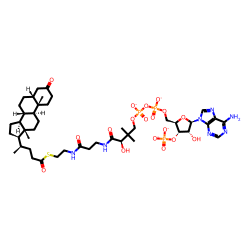
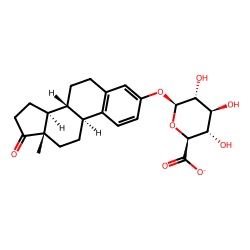
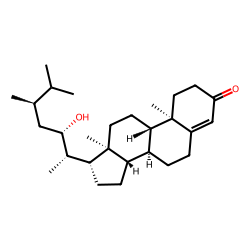
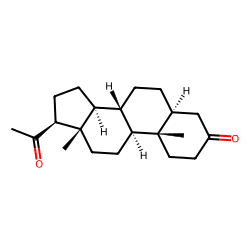
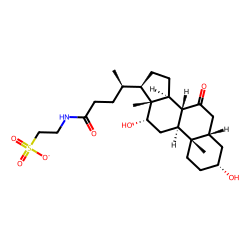
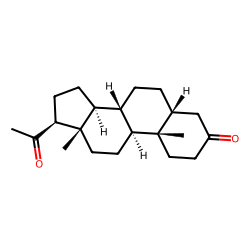
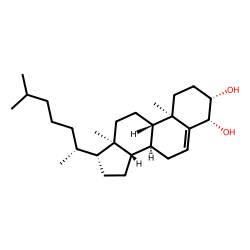
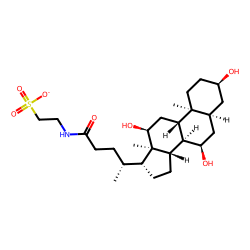
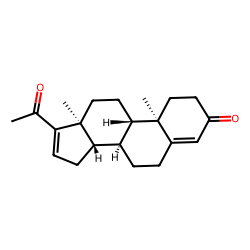
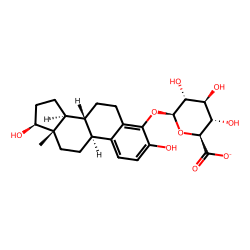
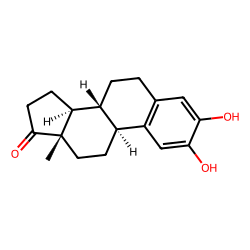
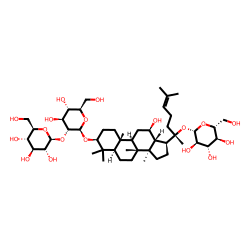
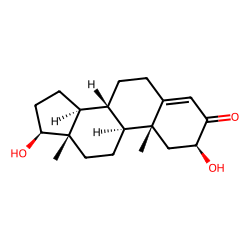
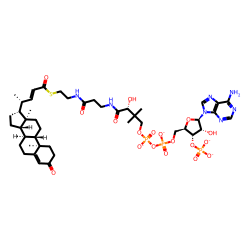
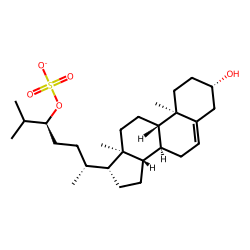
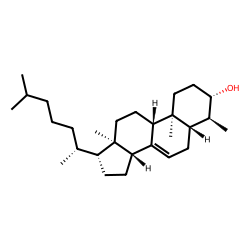
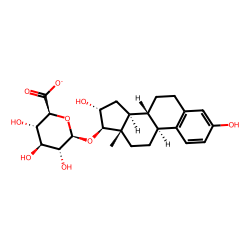
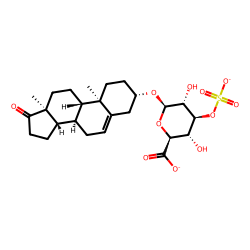
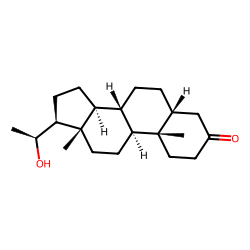
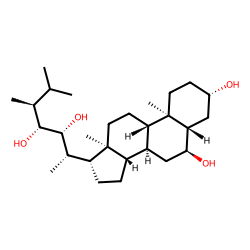
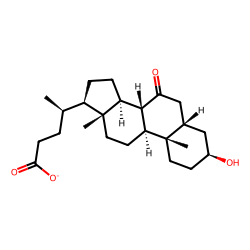
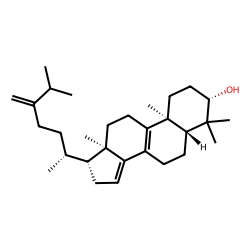
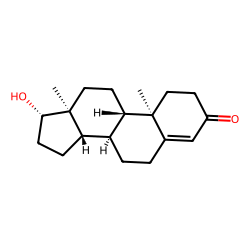
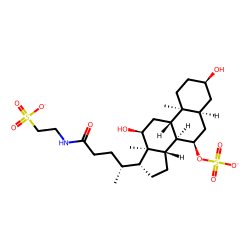
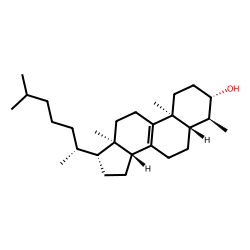
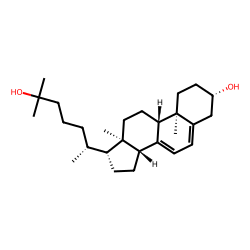
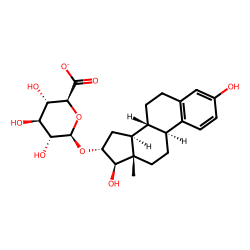
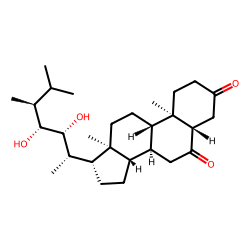
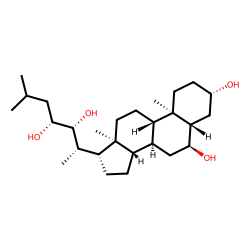
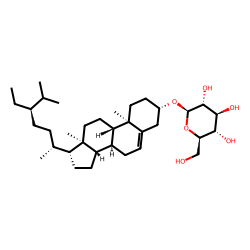
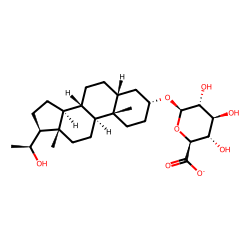
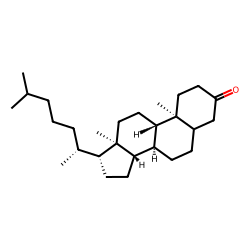
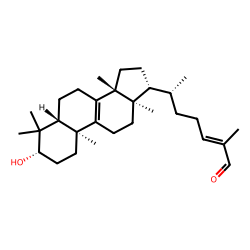
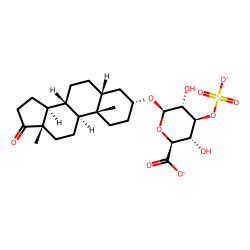
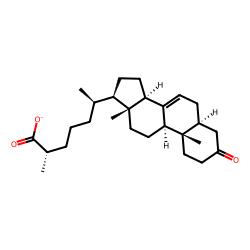
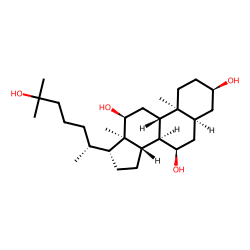
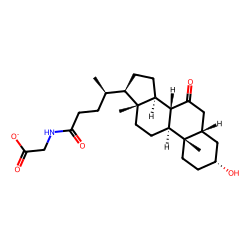
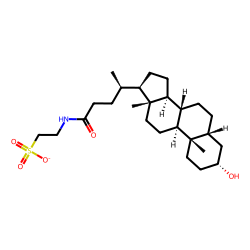
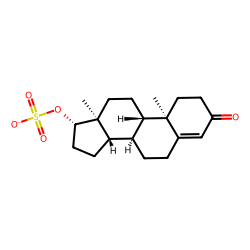
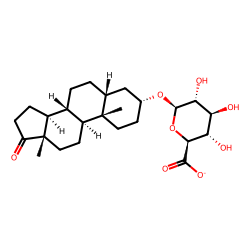
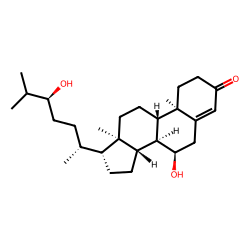
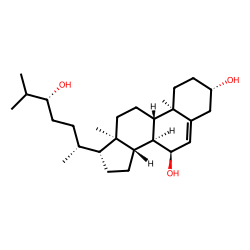
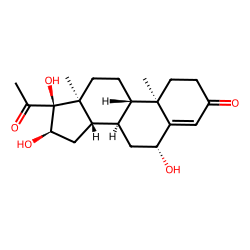
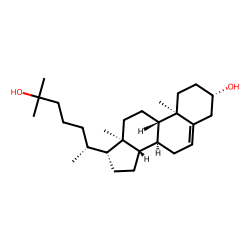
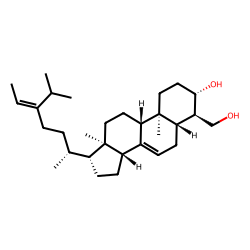
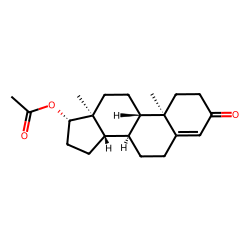
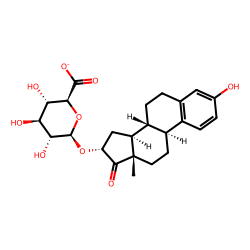
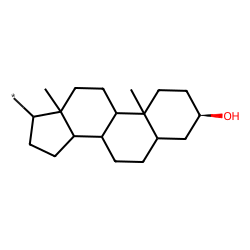
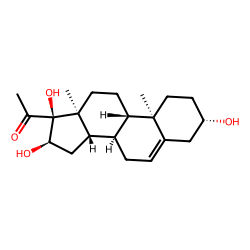
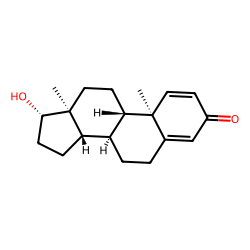
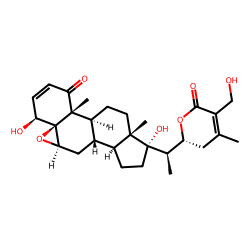
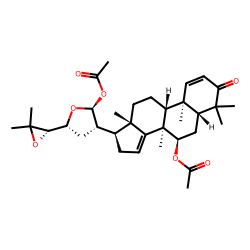
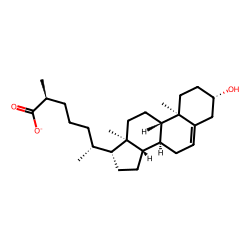
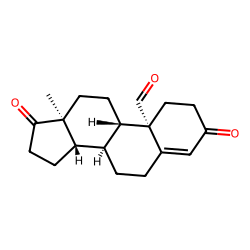
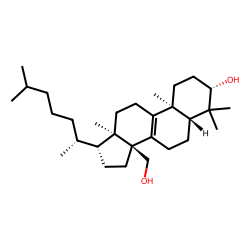
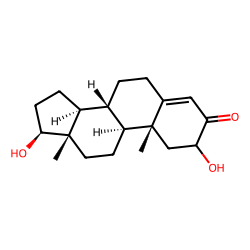
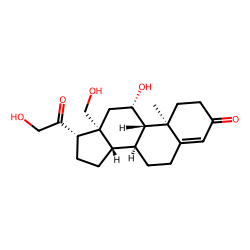
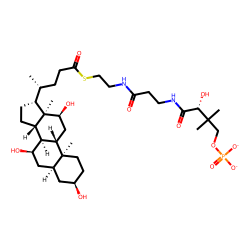
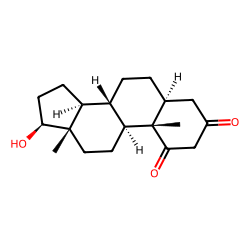
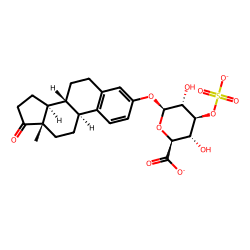
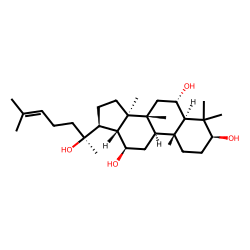
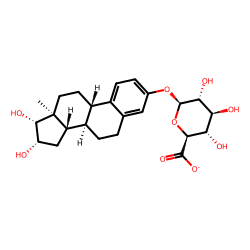
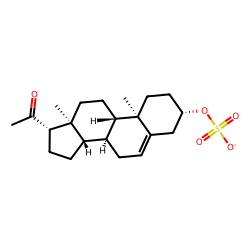
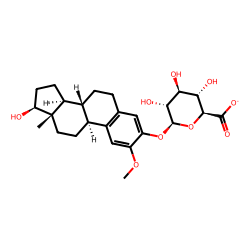
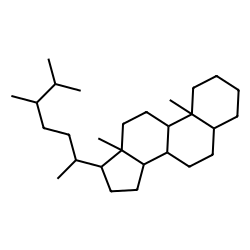
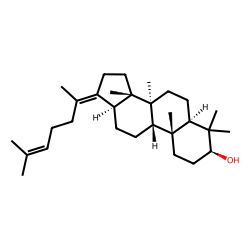
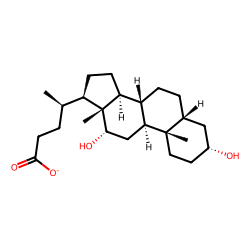
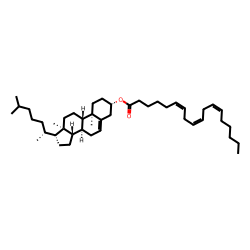
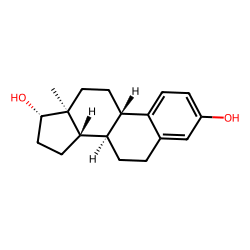
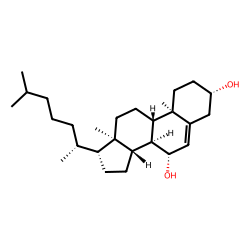
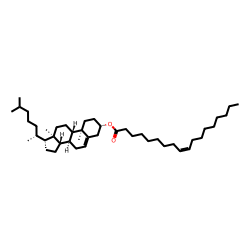
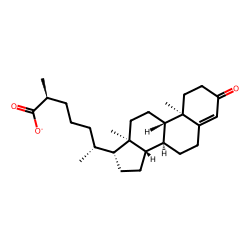
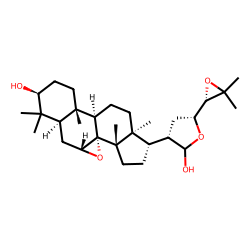
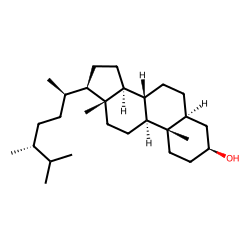
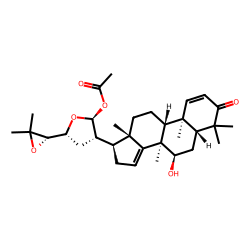
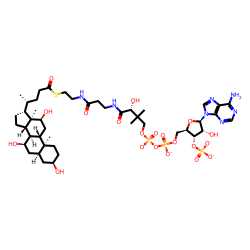
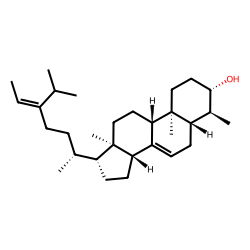
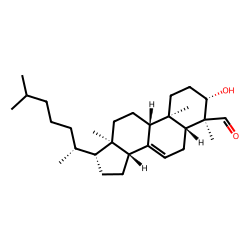
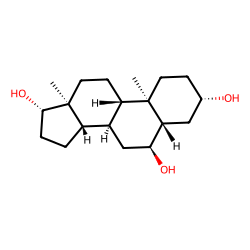
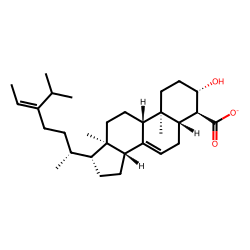
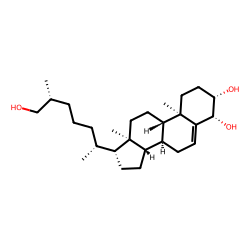
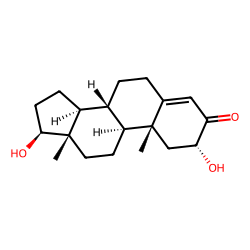
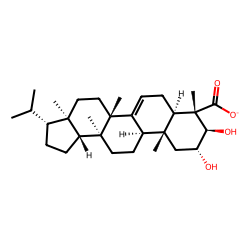
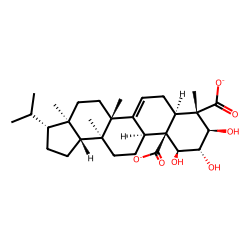
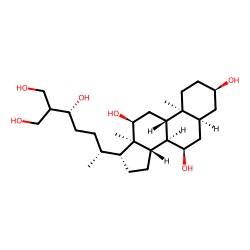
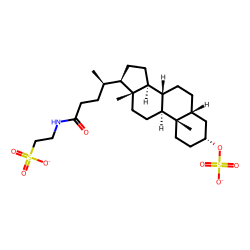
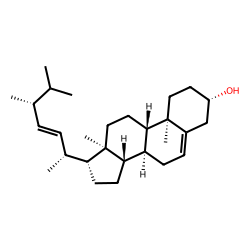
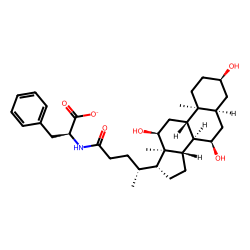
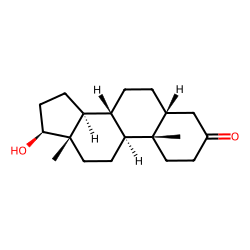
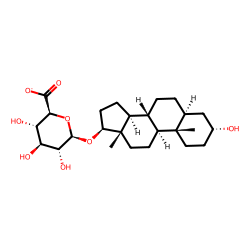
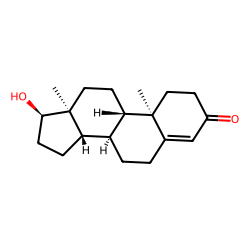
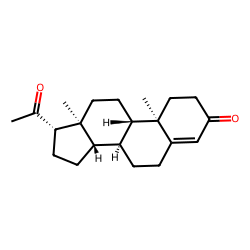
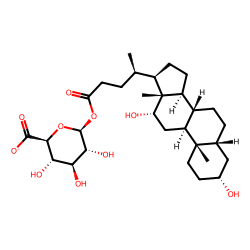
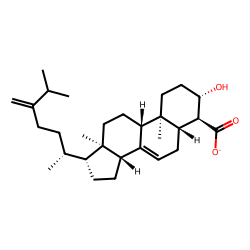
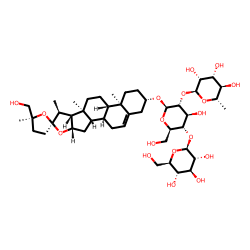
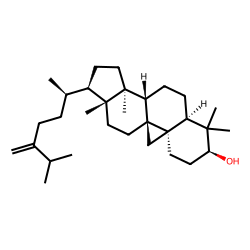
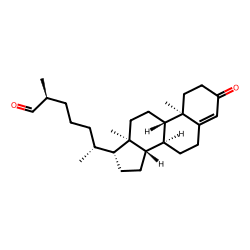
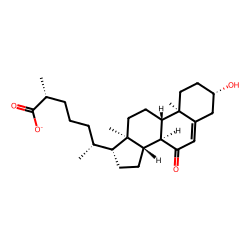
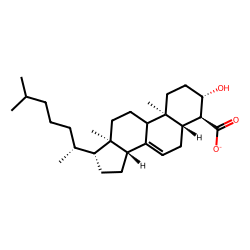
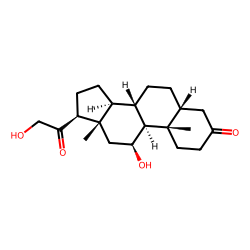
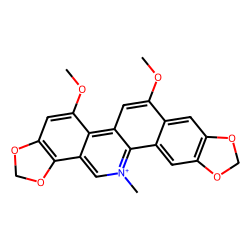
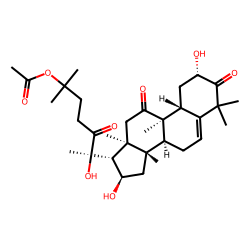
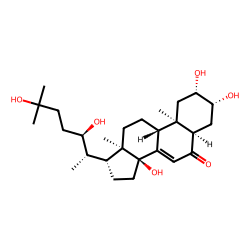
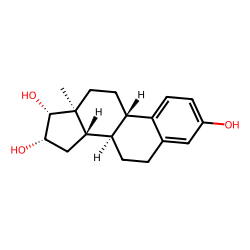
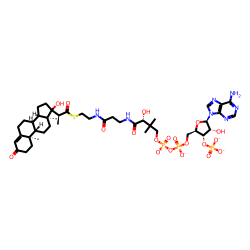
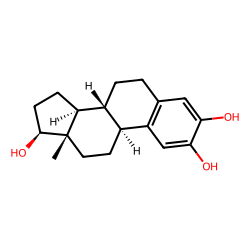
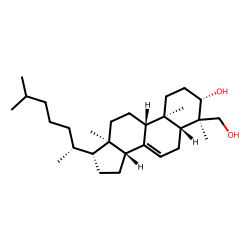
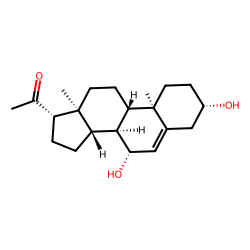
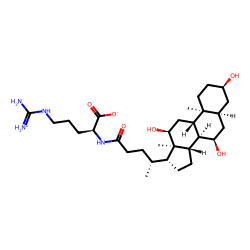
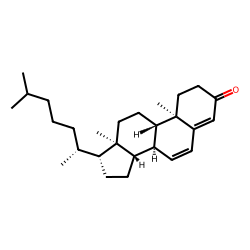
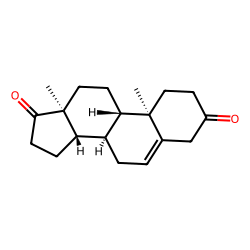
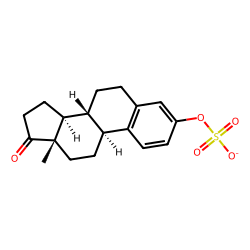
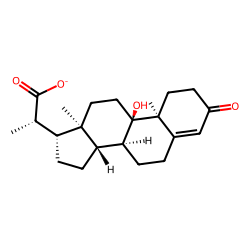
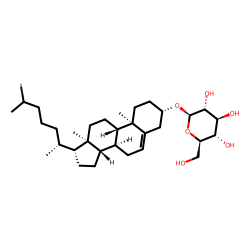
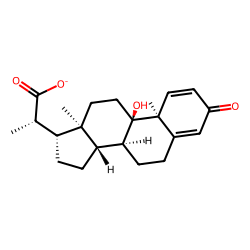
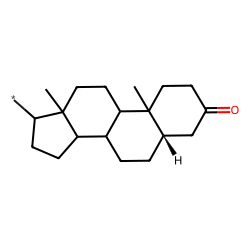
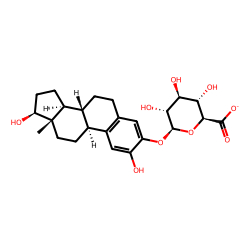
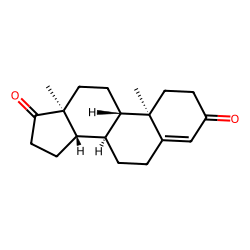
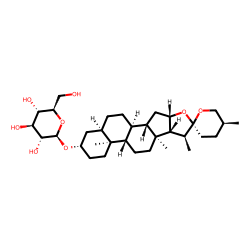
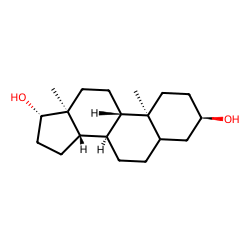
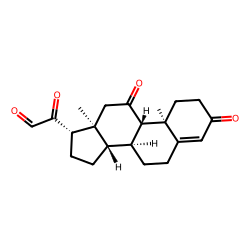
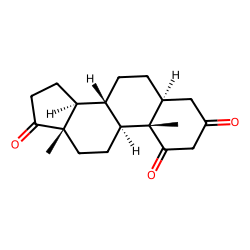
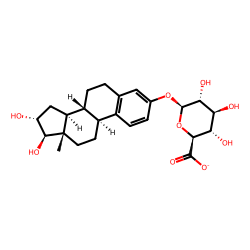

In [ ]:
display_interactive_plot(df)

### clicking through the molecules, I think the clustering worked. Clusters of molecules all look similar - have similar scaffolds, mostly.

## [EXERCISE 5] ML for predicting solubility

In [ ]:
import torch
import os


# Get PyTorch version
TORCH = torch.__version__.split('+')[0]


# Get CUDA version
CUDA = torch.version.cuda
if CUDA:
   CUDA = f"cu{CUDA.replace('.', '')}"
else:
   CUDA = "cpu"


print(f"PyTorch: {TORCH}, CUDA: {CUDA}")

PyTorch: 2.5.1, CUDA: cu124


In [ ]:
from torch_geometric.datasets import MoleculeNet

#load the solubility data from Molecule Net
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [ ]:
#make a dataframe with solubility and smiles strings
smiles_list = []
solubility_list = []

for mol_data in data:
  smiles = mol_data.smiles
  solubility = mol_data.y.item()
  smiles_list.append(smiles)
  solubility_list.append(solubility) #what units is solubility in?

df_sol = pd.DataFrame({
    'compound_id': [f"Mol_{i}" for i in range(len(smiles_list))],
    'smiles': smiles_list,
    'solubility': solubility_list
})

print(f"Dataset contains {len(df)} molecules")
df_sol.head()

Dataset contains 800 molecules


compound_id                                             smiles  solubility
0       Mol_0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...       -0.77
1       Mol_1                             Cc1occc1C(=O)Nc2ccccc2       -3.30
2       Mol_2                               CC(C)=CCCC(C)=CC(=O)       -2.06
3       Mol_3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43       -7.87
4       Mol_4                                            c1ccsc1       -1.33

In [ ]:
#Now we wwant to get the molecular fingerprints for the molecules in our solubility dataframe

# Get morgan fingerprints

df_sol['mol'] = df_sol['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

#MACCS Keys
from rdkit.Chem import MACCSkeys

def compute_maccs_fingerprints(mol):
  return np.array(MACCSkeys.GenMACCSKeys(mol))
df_sol['MACCS_FP'] = df_sol['mol'].apply(lambda x: compute_maccs_fingerprints(x) if x else None)

#Topo pairs
def compute_topo_fingerprints(mol, nBits=2048):
  return np.array(Chem.RDKFingerprint(mol, fpSize=nBits))
df_sol['Topo_FP'] = df_sol['mol'].apply(lambda x: compute_topo_fingerprints(x) if x else None)

#atom pairs
from rdkit.Chem.AtomPairs import Pairs
def compute_atom_pair_fingerprints(mol, nBits=2048):
  fp = Pairs.GetAtomPairFingerprint(mol)
  return np.array(AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits))
df_sol['Atom_Pair_FP'] = df_sol['mol'].apply(lambda x: compute_atom_pair_fingerprints(x) if x else None)

#Morgan fingerprints default settings
def compute_morgan_fp(mol, nBits=2048):
  return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits))
df_sol['Morgan_FP'] = df_sol['mol'].apply(lambda x: compute_morgan_fp(x) if x else None)

#Morgan fingerprints with different radius
def compute_morgan_fp_r3(mol, nBits=2048):
  return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=nBits))
df_sol['Morgan_FP_r3'] = df_sol['mol'].apply(lambda x: compute_morgan_fp_r3(x) if x else None)

In [ ]:
fingerprint_matrix.shape

(800, 1024)

In [ ]:
#Now we will train a model to predict solubility using the fingerprint data

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

fingerprint_types = ['Morgan_FP','MACCS_FP', 'Topo_FP', 'Atom_Pair_FP', 'Morgan_FP_r3']

for fp_type in fingerprint_types:
  print(f"\nEvaluating {fp_type}")

  #prepare data
  df_clean = df_sol.dropna(subset=[fp_type])
  X = np.stack(df_clean[fp_type].values)
  y = df_clean['solubility'].values

  #Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train model
  rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
  rf_model.fit(X_train, y_train)

  #Evaluate model
  y_pred = rf_model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  print(f"R2 Score: {r2:.4f}")
  print(f"RMSE: {rmse:.4f}")




Evaluating Morgan_FP
R2 Score: 0.7101
RMSE: 1.1706

Evaluating MACCS_FP
R2 Score: 0.7886
RMSE: 0.9996

Evaluating Topo_FP
R2 Score: 0.7904
RMSE: 0.9954

Evaluating Atom_Pair_FP
R2 Score: 0.8164
RMSE: 0.9317

Evaluating Morgan_FP_r3
R2 Score: 0.6949
RMSE: 1.2009


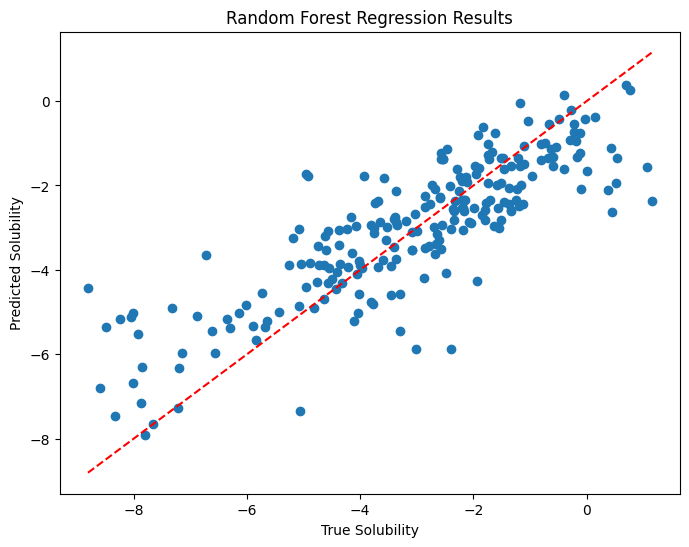

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Random Forest Regression Results')
plt.show()

### The model performs best in the middle ranges of the min/max of solubility. In the end ranges it breaks down a little.

 ## [EXERCISE 6] GNNs

In [ ]:

#load solubility data from moleculenet
data = MoleculeNet(root=".", name="ESOL") #molecular graphs are already provided!!

sample = data[5]

print("Node features(x):", sample.x.shape) #row = atom, #olumn = attribute
print("Edge index(adjecency):", sample.edge_index.shape) #adjacency list: column represents a bond between atoms
print("Edge attributes (if any):", sample.edge_attr.shape if sample.edge_attr is not None else "None")
print("Target label solubility:", sample.y)



Node features(x): torch.Size([9, 9])
Edge index(adjecency): torch.Size([2, 20])
Edge attributes (if any): torch.Size([20, 3])
Target label solubility: tensor([[-1.5000]])


In [ ]:
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, global_add_pool
import torch.nn.functional as F
from torch_geometric.data import DataLoader

In [ ]:
#make indices and split data
indices = torch.randperm(len(data))
train_size = int(0.8 * len(data)) #80% of the data
train_indices = indices[:train_size] #go up until train size (80)
test_indices = indices[train_size:] # go from train size onward (20)

#use indices to get train and test data
train_dataset = data[train_indices.tolist()]
test_dataset = data[test_indices.tolist()]

# make data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32) #don't shuffle test dataset?

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [ ]:
class SimpleGNN(torch.nn.Module):
   def __init__(self, num_node_features):
       super(SimpleGNN, self).__init__()
       self.conv1 = GCNConv(num_node_features, 16)
       self.conv2 = GCNConv(16, 16)
       self.lin = torch.nn.Linear(16, 1)

   def forward(self, data):
       x = data.x.float()  # Ensure float type
       edge_index = data.edge_index
       batch = data.batch

       x = self.conv1(x, edge_index)
       x = F.relu(x)

       x = self.conv2(x, edge_index)
       x = F.relu(x)

       x = global_add_pool(x, batch)
       x = self.lin(x)

       return x


In [ ]:
def train():
   model.train()
   total_loss = 0
   for data_batch in train_loader:
       optimizer.zero_grad() #clear gradient
       out = model(data_batch) # run molecules through model as batches
       # Ensure target is float type
       target = data_batch.y.float()
       loss = criterion(out, target)
       loss.backward()
       optimizer.step()
       total_loss += loss.item()
   return total_loss / len(train_loader)


def test(loader):
   model.eval()
   total_loss = 0
   with torch.no_grad():
       for data_batch in loader:
           out = model(data_batch) #evaluate model on test data
           # Ensure target is float type
           target = data_batch.y.float()
           loss = criterion(out, target)
           total_loss += loss.item()
   return total_loss / len(loader) # average loss across al batches is returned


In [ ]:
model = SimpleGNN(num_node_features=9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #lr is learning rate
criterion = torch.nn.MSELoss()

In [ ]:
num_epochs = 5000 #we will go through training dataset 5000 times
for epoch in range(num_epochs):
   train_loss = train()
   test_loss = test(test_loader)
   if epoch % 5 == 0:
      print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch: 0, Train Loss: 7.1008, Test Loss: 2.5430
Epoch: 5, Train Loss: 1.9748, Test Loss: 1.5768
Epoch: 10, Train Loss: 1.6275, Test Loss: 1.7089
Epoch: 15, Train Loss: 1.4400, Test Loss: 1.2222
Epoch: 20, Train Loss: 1.5009, Test Loss: 1.0957
Epoch: 25, Train Loss: 1.2425, Test Loss: 1.1107
Epoch: 30, Train Loss: 1.2511, Test Loss: 1.3540
Epoch: 35, Train Loss: 1.2206, Test Loss: 0.9840
Epoch: 40, Train Loss: 1.2519, Test Loss: 1.0736
Epoch: 45, Train Loss: 1.1637, Test Loss: 1.4157
Epoch: 50, Train Loss: 1.9680, Test Loss: 1.1682
Epoch: 55, Train Loss: 1.2450, Test Loss: 1.1690
Epoch: 60, Train Loss: 1.2195, Test Loss: 1.3123
Epoch: 65, Train Loss: 1.1469, Test Loss: 1.0244
Epoch: 70, Train Loss: 1.1551, Test Loss: 0.9799
Epoch: 75, Train Loss: 1.1310, Test Loss: 0.8907
Epoch: 80, Train Loss: 1.1947, Test Loss: 0.9195
Epoch: 85, Train Loss: 1.1124, Test Loss: 0.9632
Epoch: 90, Train Loss: 1.1342, Test Loss: 0.8887
Epoch: 95, Train Loss: 1.1713, Test Loss: 1.0860
Epoch: 100, Train Loss